# Ipython notebook for norway economy website

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys
import pystan
import scipy
import math
import re
import json
from datetime import datetime
%matplotlib inline
from pandas.io.json import json_normalize
import html5lib
import bs4
pd.options.mode.chained_assignment = None 

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Plot settings:

In [2]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.labelsize"]= 12
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [16,10]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.color_cycle"] = multi


//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Functions

In [3]:
#show categories in a json file
def show_categories(json_data):
	print(json_data["dataset"]["dimension"]["ContentsCode"])


#convert to datetime
def convert_datetime(date_series):
	if "K" in date_series[0]:
		time = date_series.apply(lambda x: x.replace("K",""))
		month = [str(int(t[-1])*3) for t in time]
		year = [str(int(t[:-1])) for t in time]
		new_date_series = [x+y for x,y in zip(year, month)]
		new_date_series = pd.to_datetime(new_date_series, format='%Y%m')
	if "M" in date_series[0]:
		time = date_series.apply(lambda x: x.replace("M",""))
		new_date_series = pd.to_datetime(time, format='%Y%m')
	return(new_date_series)
    
#convert month-date format:
yearmonth = lambda x: datetime.strptime(x, '%Y%m')

#smooth a series using lowess
def smooth_series(srs):
	x_range = [i for i in range(len(srs))]
	smoothed = sm.nonparametric.lowess(srs,x_range, frac=0.1)
	return(pd.Series(smoothed[:,1]))

### Utslipp

In [4]:
#downloaded from https://www.ssb.no/klimagassn/
utslipp = pd.read_csv("data/utslipp.csv", sep=";", skiprows=4,encoding = "cp865")

In [5]:
utslipp.columns.values

array([' ', ' .1', 'Alle kilder', 'Olje- og gassutvinning',
       'Industri og bergverk', 'Energiforsyning',
       'Oppvarming i andre nµringer og husholdninger', 'Veitrafikk',
       'Luftfart, sj°fart, fiske, motorredskaper m.m.', 'Jordbruk',
       'Andre kilder'], dtype=object)

In [6]:
utslipp.columns = ["index", "year", "total", "oil and gas", "industry", 
                   "energy generation", "heating", "traffic", "air, sea and fishing", "agriculture", "other"]
del utslipp["index"]

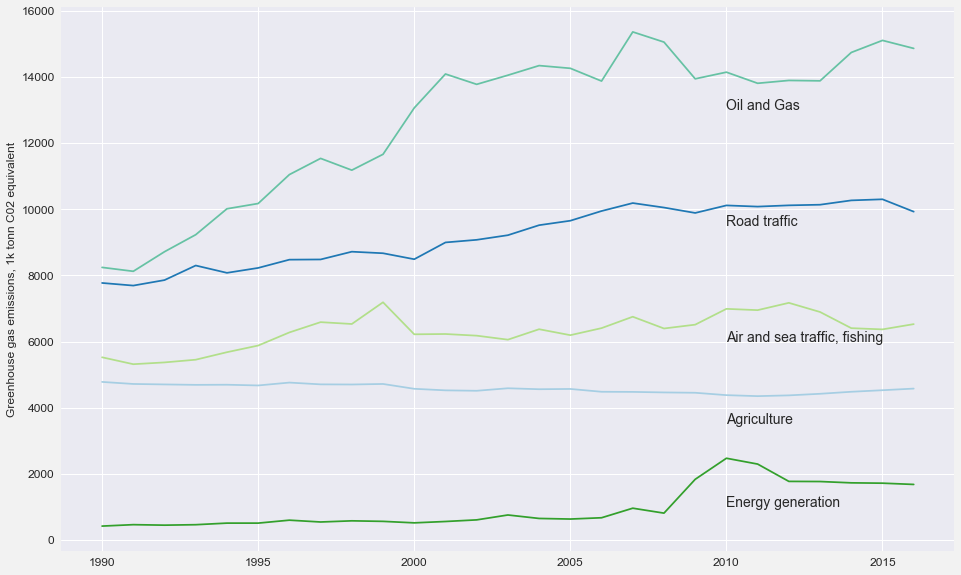

In [7]:
fig, ax = plt.subplots()
ax.plot(utslipp["year"], utslipp["oil and gas"])
ax.annotate("Oil and Gas", xy=(2010, 13000))
ax.plot(utslipp["year"], utslipp["traffic"])
ax.annotate("Road traffic", xy=(2010, 9500))
ax.plot(utslipp["year"], utslipp["agriculture"])
ax.annotate("Agriculture", xy=(2010, 3500))
ax.plot(utslipp["year"], utslipp["air, sea and fishing"])
ax.annotate("Air and sea traffic, fishing", xy=(2010, 6000))
ax.plot(utslipp["year"], utslipp["energy generation"])
ax.annotate("Energy generation", xy=(2010, 1000))
ax.set_ylabel("Greenhouse gas emissions, 1k tonn C02 equivalent")
fig.savefig("figures/CO2_emissions.png")
plt.show()

### EU ETS

In [8]:
ETS = pd.read_csv("https://www.quandl.com/api/v3/datasets/CHRIS/ICE_C3.csv?api_key=FerW555gC-wsJXPdTu8t")

In [11]:
ETS.loc[:,"Date"] = pd.to_datetime(ETS.Date)

In [12]:
ETS = ETS.sort_values("Date")

In [39]:
#data on coal prices, among others
#From BP http://tools.bp.com/energy-charting-tool.aspx?_ga=2.195451051.643627682.1498134543-1852369484.1498134543#/ep/coal_prices/unit2/$-t/view/line/
bp_coal = pd.read_excel("data/statistical-review-of-world-energy-2017-workbook.xlsx", sheetname="Coal - Prices", skiprows=1, skip_footer=6)

In [47]:
bp_coal = bp_coal.iloc[1:, 0:8]
bp_coal.columns = [['year', 'Northwest Europe marker price',
       'US Central Appalachian coal spot price index',
       'Japan steam spot cif price', 'China Qinhuangdao spot price',
       'Japan coking coal import cif price',
       'Japan steam coal import cif price', 'Asian marker price']]
bp_coal.loc[:, "year"] = pd.to_datetime(bp_coal.year.astype(int), format="%Y")

In [48]:
bp_coal.head()

year  Northwest Europe marker price  \
6  1992-01-01                          38.53   
7  1993-01-01                          33.68   
8  1994-01-01                          37.18   
9  1995-01-01                          44.50   
10 1996-01-01                          41.25   

   US Central Appalachian coal spot price index Japan steam spot cif price  \
6                                       28.5345                          -   
7                                        29.854                          -   
8                                       31.7162                          -   
9                                       27.0064                          -   
10                                      29.8623                          -   

   China Qinhuangdao spot price  Japan coking coal import cif price  \
6                             -                           57.815833   
7                             -                           55.258333   
8                             -                           51.765000   
9                             -                           54.468333   
10                            -                           56.679167   

    Japan steam coal import cif price Asian marker price  
6                           48.454167                  -  
7                           45.711667                  -  
8                           43.661667                  -  
9                           47.575000                  -  
10                          49.535833                  -

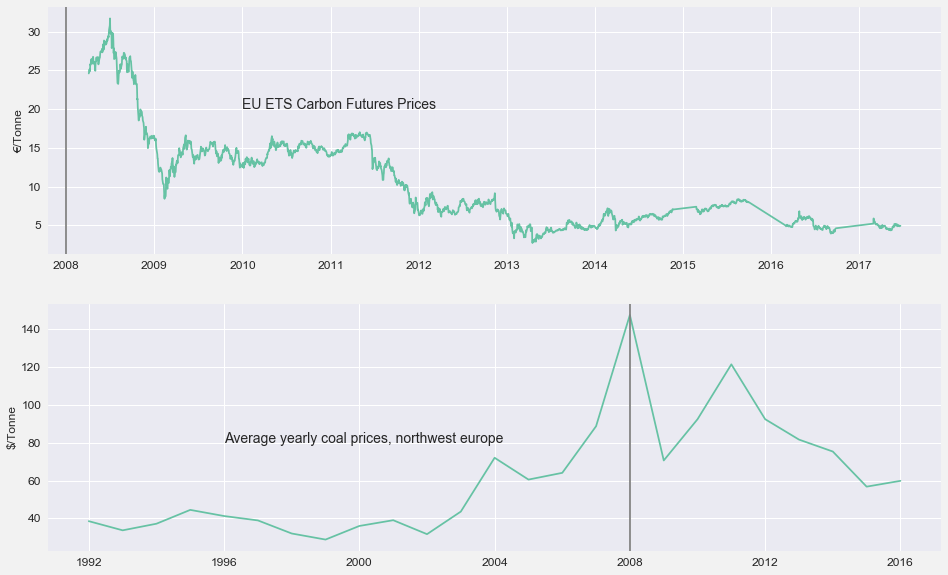

In [56]:
ETS.head()
fig, ax = plt.subplots(2)
ax[0].plot(ETS.Date, ETS.Settle)
ax[0].set_ylabel("€/Tonne")
ax[0].annotate("EU ETS Carbon Futures Prices", xy=(pd.to_datetime("2010-01-01"), 20))
ax[0].axvline(pd.to_datetime("2008-01-01"),color="grey")
ax[1].plot(bp_coal.year, bp_coal["Northwest Europe marker price"])
ax[1].set_ylabel("$/Tonne")
ax[1].annotate("Average yearly coal prices, northwest europe", xy=(pd.to_datetime("1996-01-01"), 80))
ax[1].axvline(pd.to_datetime("2008-01-01"),color="grey")
fig.savefig("figures/carbon_prices.png")
plt.show()

### Electricity prices

Data from Nord Pool Spot

In [118]:
from urllib.request import urlopen
from bs4 import BeautifulSoup


In [256]:
def clean_elspot_data(url, skiprows=0):
    df = urlopen(url)
    string_file = ""
    row=0
    for line in df.readlines():
        if row>=skiprows:
            line = str(line)    
            line = line.replace("b\'", "") 
            line = line.replace("\\r", "") 
            line = line.replace("\\n", "")   
            line = line.replace("\'", "") 
            line = line.replace("\\t", "")
            string_file += line
            row+=1
        else:
            None
    start = string_file.rfind("<html>")
    string_file = string_file[start:]
    table = pd.read_html(string_file, skiprows=2, header=0)
    return(table[0])

In [257]:
url = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/elspot-prices_2001_monthly_eur.xls"
table = clean_elspot_data(url)
table

Unnamed: 0   SYS    SE    FI   DK1   DK2  Oslo  Kr.sand  Bergen  Molde  \
0    01 - Jan  2046  2047  2046  2064  2285  2047     2047    2047   2041   
1    01 - Feb  2706  2713  2713  2593  2713  2690     2690    2690   2718   
2    01 - Mar  2586  2580  2578  2498  2580  2584     2584    2584   2613   
3    01 - Apr  2646  2636  2610  2603  2635  2655     2655    2655   2654   
4    01 - May  2407  2177  2177  2409  2177  2395     2395    2395   2558   
5    01 - Jun  2528  2523  2516  2606  2550  2527     2527    2527   2551   
6    01 - Jul  2263  2232  2232  2317  2326  2234     2234    2234   2340   
7    01 - Aug  2136  2113  2114  2345  2116  2117     2117    2117   2202   
8    01 - Sep  2088  1935  1944  2313  2060  2167     2167    2167   2066   
9    01 - Oct  1910  1887  1887  2163  1932  1883     1883    1883   1987   
10   01 - Nov  2141  2159  2159  2150  2228  2127     2127    2127   2143   
11   01 - Dec  2361  2472  2472  2451  2689  2314     2314    2314   2312   

    Tr.heim  Troms\xc3\xb8  
0      2041           2041  
1      2718           2718  
2      2613           2589  
3      2654           2647  
4      2558           2527  
5      2551           2552  
6      2340           2340  
7      2202           2202  
8      2066           2066  
9      1987           1987  
10     2143           2143  
11     2312           2312

In [146]:
years = [y for y in range(2000, 2018)]
years = [str(y) for y in years]
start = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/elspot-prices_"
end = "_monthly_eur.xls"
urls = []
for year in years:
    urls.append(start+year+end)


In [147]:
tables=[]
for t, url in enumerate(urls):
    tables.append(clean_elspot_data(url))

In [151]:
elspot = pd.concat(tables)

In [157]:
elspot.columns= ['Bergen', 'DK1', 'DK2', 'EE', 'ELE', 'FI', 'FRE', 'KT', 'Kristiansand',
       'LT', 'LV', 'Molde', 'Oslo', 'SE', 'SE1', 'SE2', 'SE3', 'SE4',
       'SYS', 'Trondheim', 'Tromsoe', 'date']

In [158]:
elspot.head()

Bergen     DK1  DK2  EE  ELE      FI  FRE  KT  Kristiansand  LT    ...     \
0  1528.0  1779.0  NaN NaN  NaN  1869.0  NaN NaN        1528.0 NaN    ...      
1  1287.0  1431.0  NaN NaN  NaN  1292.0  NaN NaN        1287.0 NaN    ...      
2  1134.0  1453.0  NaN NaN  NaN  1249.0  NaN NaN        1134.0 NaN    ...      
3  1265.0  1593.0  NaN NaN  NaN  1301.0  NaN NaN        1265.0 NaN    ...      
4   745.0  1680.0  NaN NaN  NaN  1431.0  NaN NaN         745.0 NaN    ...      

     Oslo      SE  SE1  SE2  SE3  SE4     SYS  Trondheim  Tromsoe      date  
0  1528.0  1869.0  NaN  NaN  NaN  NaN  1622.0     1741.0   1741.0  00 - Jan  
1  1287.0  1292.0  NaN  NaN  NaN  NaN  1289.0     1291.0   1291.0  00 - Feb  
2  1134.0  1232.0  NaN  NaN  NaN  NaN  1178.0     1191.0   1191.0  00 - Mar  
3  1265.0  1300.0  NaN  NaN  NaN  NaN  1280.0     1273.0   1273.0  00 - Apr  
4   745.0  1426.0  NaN  NaN  NaN  NaN   951.0      937.0    937.0  00 - May  

[5 rows x 22 columns]

In [161]:
elspot.loc[:, "date"] = pd.to_datetime(elspot["date"], format = "%y - %b")

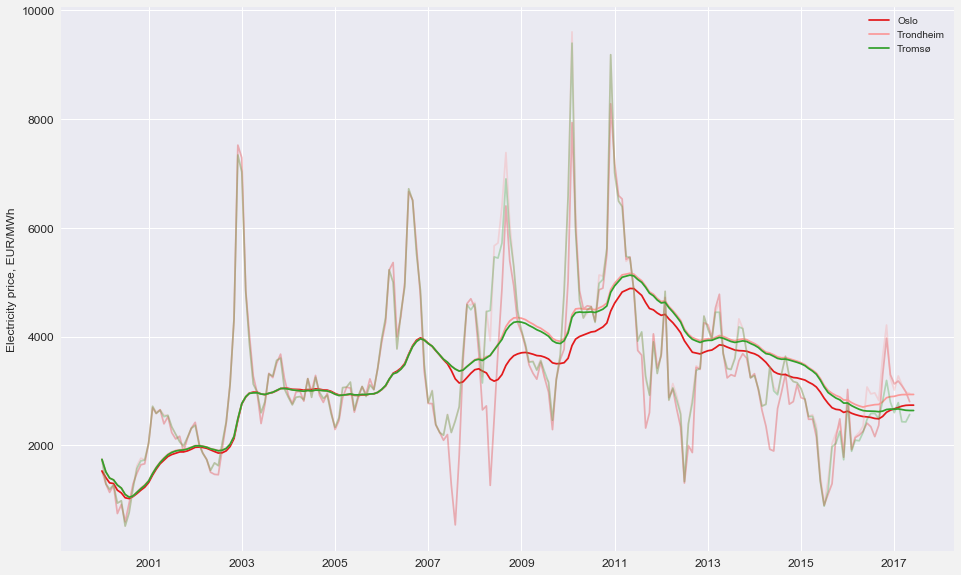

In [224]:
fig, ax = plt.subplots()
ax.plot(elspot["date"], elspot["Oslo"], color="#e31a1c", alpha=.3, label="")
ax.plot(elspot["date"], elspot["Oslo"].ewm(min_periods=0,ignore_na=False,adjust=True,span=36).mean(), color="#e31a1c", label="Oslo")
ax.plot(elspot["date"], elspot["Trondheim"], color='#fb9a99', alpha=.3, label="")
ax.plot(elspot["date"], elspot["Trondheim"].ewm(min_periods=0,ignore_na=False,adjust=True,span=36).mean(), color='#fb9a99', label="Trondheim")
ax.plot(elspot["date"], elspot["Tromsoe"], color='#33a02c', alpha=.3, label="")
ax.plot(elspot["date"], elspot["Tromsoe"].ewm(min_periods=0,ignore_na=False,adjust=True,span=36).mean(), color='#33a02c', label="Tromsø")
ax.set_ylabel("Electricity price, EUR/MWh")
ax.legend()
fig.savefig("figures/electricity_prices.png")
plt.show()
#'#33a02c','#fb9a99','#e31a1c','#fdbf6f'

#### Wind Power

In [204]:
years = [str(y) for y in range(2013, 2018)]
urls = ["http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-per-country_"+year+"_daily.xls" for year in years]

['http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-per-country_2013_daily.xls',
 'http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-per-country_2014_daily.xls',
 'http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-per-country_2015_daily.xls',
 'http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-per-country_2016_daily.xls',
 'http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-per-country_2017_daily.xls']

In [206]:
wds = []
for url in urls:
    wds.append(clean_elspot_data(url))
wind_data = pd.concat(wds) 

In [210]:
wind_data.columns = ['DK1', 'DK2', 'EE', 'LT', 'LV', 'SE1', 'SE2', 'SE3', 'SE4',
       'date']
wind_data.head()

DK1    DK2    EE    LT  LV  SE1  SE2  SE3  SE4        date
0  20882  11388  3633  3377 NaN  NaN  NaN  NaN  NaN  01-01-2013
1  26814  12516  1502  2370 NaN  NaN  NaN  NaN  NaN  02-01-2013
2  53823  19333   726  2942 NaN  NaN  NaN  NaN  NaN  03-01-2013
3  50590  15665   742  2426 NaN  NaN  NaN  NaN  NaN  04-01-2013
4  11754   1958  2058  2098 NaN  NaN  NaN  NaN  NaN  05-01-2013

In [212]:
wind_data.loc[:, "date"] = pd.to_datetime(wind_data["date"], format="%d-%m-%Y")

In [213]:
wind_data["DK"] = wind_data["DK1"] + wind_data["DK2"]

In [214]:
wind_data["SE"] = wind_data["SE1"] + wind_data["SE2"] + wind_data["SE3"] + wind_data["SE4"]

##### Norwegian data

In [20]:
n_wind = pd.read_csv("https://www.nve.no/Media/4197/produksjonsserier_vindkraft_2000-2015.csv", encoding = "cp865", sep=";")

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
n_wind.columns.values
prod_var = ['fjeldskår_modellert_produksjonsprofil',
       'sandøy_modellert_produksjonsprofil',
       'mehuken_modellert_produksjonsprofil',
       'hundhammer_modellert_produksjonsprofil',
       'havøygavlen_modellert_produksjonsprofil',
       'Hitra_modellert_produksjonsprofil',
       'Kjøllefjord_modellert_produksjonsprofil',
       'valsneset_modellert_produksjonsprofil',
       'Smøla_modellert_produksjonsprofil',
       'Bessakerfjellet_modellert_produksjonsprofil',
       'Nygårdsfjellet_modellert_produksjonsprofil',
       'Høg_jæren_modellert_produksjonsprofil',
       'Åsen_II_modellert_produksjonsprofil',
       'Fakken_modellert_produksjonsprofil',
       'Ytre_vikna_modellert_produksjonsprofil',
       'Lista_modellert_produksjonsprofil',
       'midtfjellet_modellert_produksjonsprofil',
       'Raggovidda modellert produksjon']
kap_var = ['Fjeldskår [MW]', 'Sandøy [MW]', 'Mehuken [MW]',
       'Hundhammerfjellet [MW]', 'Havøgavlen [MW]', 'Hitra [MW]',
       'Kjøllefjord [MW]', 'Valsneset [MW]', 'Smøla [MW]',
       'Bessakerfjellet [MW]', 'Nygårdsfjellet [MW]', 'Høg-Jæren [MW]',
       'Åsen II [MW]', 'Fakken [MW]', 'Ytre Vikna [MW]', 'Lista [MW]',
       'Midtfjellet [MW]', 'Raggovidda [MW]']

array(['Date/Time', 'Fjeldskår [MW]', 'Sandøy [MW]', 'Mehuken [MW]',
       'Hundhammerfjellet [MW]', 'Havøgavlen [MW]', 'Hitra [MW]',
       'Kjøllefjord [MW]', 'Valsneset [MW]', 'Smøla [MW]',
       'Bessakerfjellet [MW]', 'Nygårdsfjellet [MW]', 'Høg-Jæren [MW]',
       'Åsen II [MW]', 'Fakken [MW]', 'Ytre Vikna [MW]', 'Lista [MW]',
       'Midtfjellet [MW]', 'Raggovidda [MW]',
       'fjeldskår_modellert_produksjonsprofil',
       'sandøy_modellert_produksjonsprofil',
       'mehuken_modellert_produksjonsprofil',
       'hundhammer_modellert_produksjonsprofil',
       'havøygavlen_modellert_produksjonsprofil',
       'Hitra_modellert_produksjonsprofil',
       'Kjøllefjord_modellert_produksjonsprofil',
       'valsneset_modellert_produksjonsprofil',
       'Smøla_modellert_produksjonsprofil',
       'Bessakerfjellet_modellert_produksjonsprofil',
       'Nygårdsfjellet_modellert_produksjonsprofil',
       'Høg_jæren_modellert_produksjonsprofil',
       'Åsen_II_modellert_produksjonsp

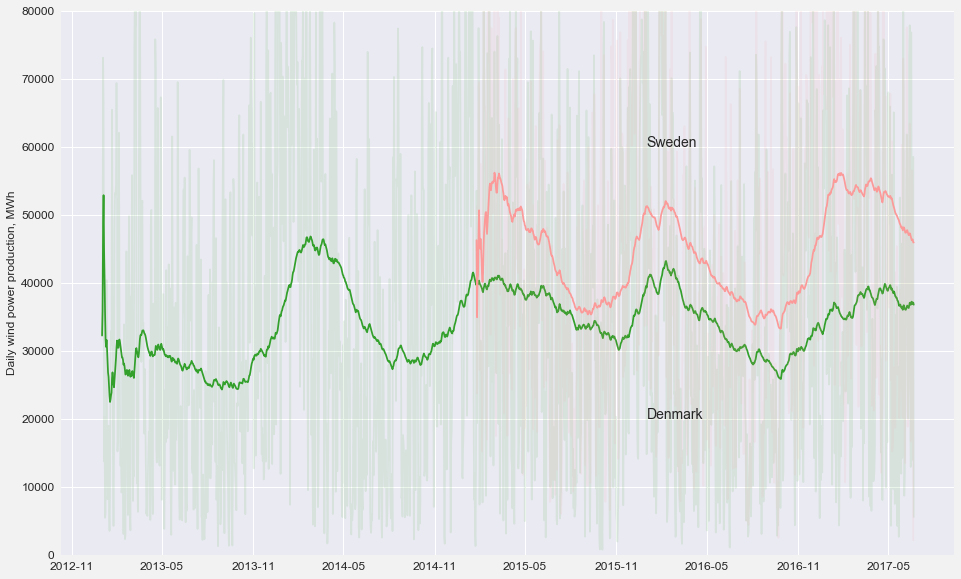

In [222]:
text_date = pd.to_datetime("2016-01-01")
fig, ax = plt.subplots()
ax.plot(wind_data["date"], wind_data["DK"], alpha=.1, color='#33a02c', label="Denmark")
ax.plot(wind_data["date"], wind_data["DK"].ewm(min_periods=0,ignore_na=False,adjust=True,span=200).mean(), color='#33a02c', label="")
ax.plot(wind_data["date"], wind_data["SE"], alpha=.1, color ='#fb9a99' , label="Sweden")
ax.plot(wind_data["date"], wind_data["SE"].ewm(min_periods=0,ignore_na=False,adjust=True,span=200).mean(), color= '#fb9a99', label="")
ax.annotate("Sweden", xy=(text_date, 60000))
ax.annotate("Denmark", xy=(text_date, 20000))
ax.set_ylim(0, 80000)
ax.set_ylabel("Daily wind power production, MWh")
fig.savefig("figures/nordic_wind.png")
plt.show()
#'#33a02c','#fb9a99','#e31a1c','#fdbf6f'

#### Exchange

In [258]:
url = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/exchange-per-country_2013_daily.xls"
test = clean_elspot_data(url)

In [259]:
test.head()

Unnamed: 0  NO net exchange  SE net exchange  FI net exchange  \
0  01-01-2013            83329           -67191            55059   
1  02-01-2013            -1841           -56723            67140   
2  03-01-2013            29772           -67686            67076   
3  04-01-2013             3256           -67493            70495   
4  05-01-2013           -15080           -58773            58704   

   DK net exchange  EE net exchange  LV net exchange  LT net exchange  
0             1490            -1780              NaN            12895  
1            -1123            -4723              NaN            17650  
2           -25996            -4887              NaN            19580  
3           -16662            -2032              NaN            18012  
4            17268            -2774              NaN            17338

### Business Tendency survey

In [5]:
BTS = pd.read_csv("http://data.ssb.no/api/v0/dataset/166316.csv?lang=en")

In [6]:
BTS.head()
BTS.columns = ["grouping", "adjustment", "date", "content", "value"]


### Import and Export

In [12]:
ih = pd.read_csv("http://data.ssb.no/api/v0/dataset/58962.csv?lang=en", 
	sep=",", decimal=".", na_values = [".", ".."])


In [13]:
ih.head()

trade flow     time contents Value by trade flow and time
0  Itot Total imports  1980M01    Value                         6937
1  Itot Total imports  1980M02    Value                         6750
2  Itot Total imports  1980M03    Value                         7332
3  Itot Total imports  1980M04    Value                         6364
4  Itot Total imports  1980M05    Value                         6840

In [14]:

ih.columns = ["flow", "date", "variable", "value"]
ih.date = convert_datetime(ih.date)
ih.flow.unique()

array(['Itot Total imports', 'Itotuskip Imports excl. ships',
       'Itotuso Imports excl. ships and oil platforms',
       'Itotusor Imports excl. ships, oil platforms and crude oil',
       'Etot Total exports', 'Etotueski Exports excl. elderly ships',
       'Etotuskip Exports excl. ships',
       'Etotuso Exports excl. ships and oil platforms',
       'Etotusorn Mainland exports',
       'Hbtot Trade balance (Total exports - total imports)',
       'Hbtotuso Trade balance (Exports - imports, both excl. ships and oil platforms)',
       'Hbtusorn Trade balance (Mainland exports - imports excl. ships and oil platforms)',
       'Iskip Imports of ships', 'Iskipeld Imports of elderly ships',
       'Iskipnye Imports of new ships', 'Iplat Imports of oil platforms',
       'Iskipplat Imports of ships and oil platforms',
       'Eolje Exports of crude oil', 'Egass Exports of natural gas',
       'Ekondens Exports of condensates',
       'Eoljegass Exports of crude oil, natural gas and co

In [15]:
include = ['Etotusorn Mainland exports', 'Eoljegass Exports of crude oil, natural gas and condensates']
eksport  = ih[ih.flow.isin(include)]
eksport["value"] = eksport.value.astype(float)
eksport_w = eksport.pivot(index='date', columns='flow', values='value')
eksport_w.reset_index(inplace=True)

eksport_w.columns = ["date", "petroleum_export", "non_petroleum_export"]


In [16]:
eksport_w["perc_petroleum_export"] = eksport_w.petroleum_export.pct_change(periods=12)
eksport_w["smooth_petroleum_export"] = eksport_w.petroleum_export.rolling(window=12).mean()
eksport_w["perc_non_petroleum_export"] = eksport_w.non_petroleum_export.pct_change(periods=12)
eksport_w["smooth_non_petroleum_export"] = eksport_w.non_petroleum_export.rolling( window=12).mean()


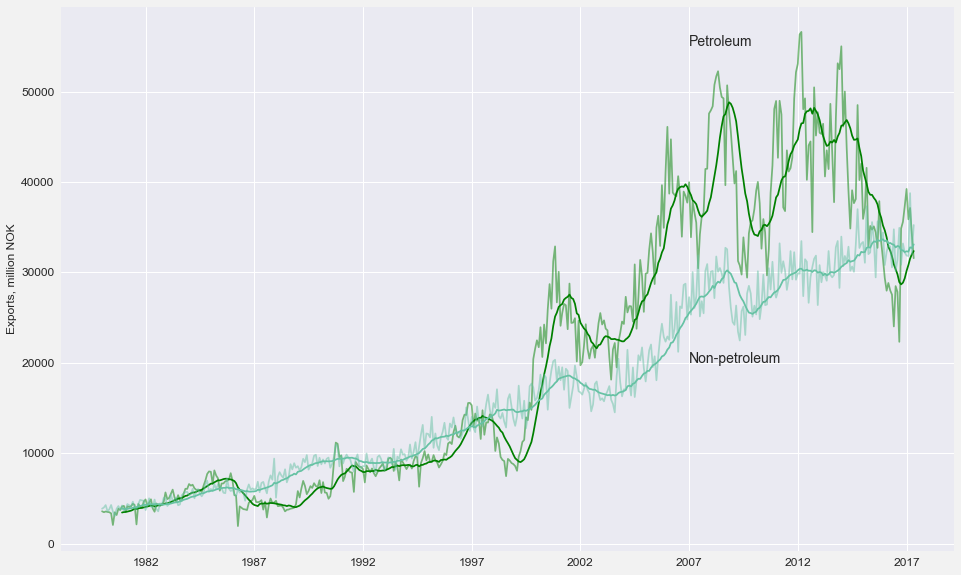

In [22]:
start = datetime.strptime('01012007', '%d%m%Y')

fig, ax = plt.subplots()
ax.plot()
ax.plot(eksport_w.date, eksport_w.petroleum_export, color="green", alpha=.5)
ax.plot(eksport_w.date, eksport_w.smooth_petroleum_export, color="green")
ax.plot(eksport_w.date, eksport_w.non_petroleum_export, color='#66c2a4', alpha=.5)
ax.plot(eksport_w.date, eksport_w.smooth_non_petroleum_export, color='#66c2a4')
ax.annotate('Petroleum', xy=(start, 55000))
ax.annotate('Non-petroleum', xy=(start, 20000))
ax.set_ylabel("Exports, million NOK")
fig.savefig("figures/exports_levels.png")
plt.show()

#### YoY pct change

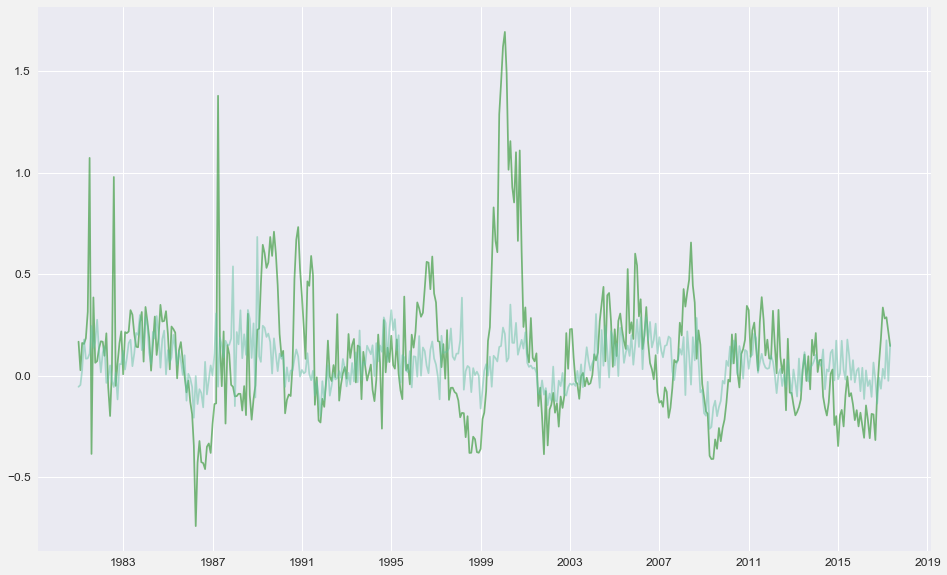

In [23]:
fig, ax = plt.subplots()
ax.plot()
ax.plot(eksport_w.date, eksport_w.perc_petroleum_export, color="green", alpha=.5)
#ax.plot(eksport_w.date, eksport_w.smooth_petroleum_export, color="green")
ax.plot(eksport_w.date, eksport_w.perc_non_petroleum_export, color='#66c2a4', alpha=.5)
#ax.plot(eksport_w.date, eksport_w.smooth_non_petroleum_export, color='#66c2a4')
#ax.annotate('Petroleum', xy=(start, 55000))
#ax.annotate('Non-petroleum', xy=(start, 20000))
#ax.set_ylabel("Exports, million NOK")
#fig.savefig("figures/exports_perc.png", bbox_inches='tight')
plt.show()

#### Trade balance

In [26]:
include = ['Hbtot Trade balance (Total exports - total imports)', "Hbtusorn Trade balance (Mainland exports - imports excl. ships and oil platforms)"]
bal  = ih[ih.flow.isin(include)]
bal["value"] = bal.value.astype(float)
bal_w = bal.pivot(index='date', columns='flow', values='value')
bal_w.reset_index(inplace=True)
bal_w.columns = ["date", "trade_bal", "trade_bal_ex_pet"]



In [27]:
bal_w["smooth_bal"] = bal_w.trade_bal.rolling(window=12).mean()
bal_w["smooth_bal_ex_pet"] = bal_w.trade_bal_ex_pet.rolling(window=12).mean()


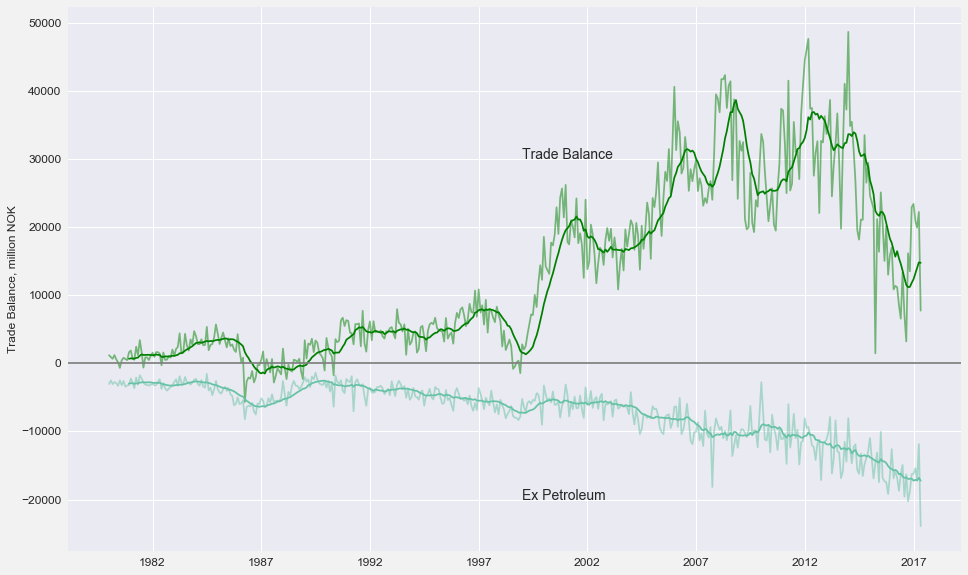

In [28]:
start = datetime.strptime('01011999', '%d%m%Y')

fig, ax = plt.subplots()
ax.plot(bal_w.date, bal_w.trade_bal, color="green", alpha=.5)
ax.plot(bal_w.date, bal_w.smooth_bal, color="green")
ax.plot(bal_w.date, bal_w.trade_bal_ex_pet, color="#66c2a4", alpha=.5)
ax.plot(bal_w.date, bal_w.smooth_bal_ex_pet, color="#66c2a4")
ax.annotate('Trade Balance', xy=(start, 30000))
ax.annotate('Ex Petroleum', xy=(start, -20000))
ax.set_ylabel("Trade Balance, million NOK")
plt.axhline(y=0.0, color='grey', linestyle='-')
fig.savefig("figures/trade_bal.png")
plt.show()

# Employment

In [29]:

employment_json = pd.read_json("https://data.ssb.no/api/v0/dataset/1054.json?lang=en")

age_labels = employment_json["dataset"]["dimension"]["Alder"]
sex_labels = employment_json["dataset"]["dimension"]["Kjonn"]
content_labels = employment_json["dataset"]["dimension"]["ContentsCode"]


In [30]:
employment = pd.read_csv("https://data.ssb.no/api/v0/dataset/1054.csv?lang=en")

employment.columns = ["sex", "age", "contents", "time", "value"]

unemp_1000 = employment[employment.contents == 'Unemployment (LFS) (1 000 persons), seasonally adjusted']
#unemp_1000 = unemp_1000[unemp_1000.sex=="0 Both sexes"]
unemp_1000 = unemp_1000[unemp_1000.age=="25-74 25-74 years"]
unemp_1000 = unemp_1000[["time", "sex", "value"]]

unemp_1000["time"] = unemp_1000.time.apply(lambda x:  x.replace("M", ""))
unemp_1000["time"] = pd.to_datetime(unemp_1000["time"], format="%Y%m")

unemp_1000["value"][unemp_1000.value == ".."] = np.nan
unemp_1000["value"] = unemp_1000.value.astype(float)

unemp_1000.columns =["date", "sex", "value"]
unemp_1000["sex"] = unemp_1000.sex.apply(lambda x: x[2:])


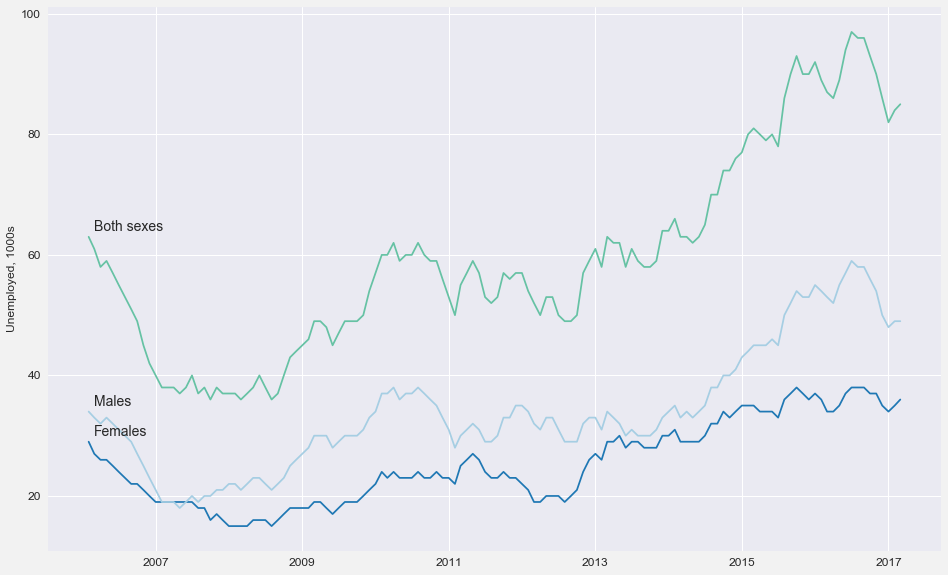

In [31]:
fig, ax = plt.subplots()
start = datetime.strptime('01032006', '%d%m%Y')
unemp_by_sex = unemp_1000.groupby("sex")
for unemp in unemp_by_sex:
	ax.plot(unemp[1].date, unemp[1].value, label=unemp[0])
	ax.annotate(unemp[0], xy=(start, np.array(unemp[1].value)[0]+1))
ax.set_ylabel("Unemployed, 1000s")
#ax.set_xlim(datetime.strptime('01012016', '%d%m%Y'))
fig.savefig("figures/unemployment.png")
plt.show()

In [32]:
emp_perc_sa = employment[employment.contents == "Employed persons in per cent of the population, seasonally adjusted"].copy()
emp_perc_sa.is_copy = False

emp_perc_sa = emp_perc_sa[emp_perc_sa.age=="25-74 25-74 years"]
emp_perc_sa = emp_perc_sa[["time", "sex", "value"]]

emp_perc_sa.loc[:,"time"] = emp_perc_sa.time.apply(lambda x:  x.replace("M", ""))
emp_perc_sa.loc[:,"time"] = pd.to_datetime(emp_perc_sa["time"], format="%Y%m")

emp_perc_sa.loc[:,"value"][emp_perc_sa.value == ".."] =np.nan
emp_perc_sa.loc[:,"value"] = emp_perc_sa.value.astype(float)

emp_perc_sa.columns =["date", "sex", "value"]
emp_perc_sa.loc[:,"sex"] = emp_perc_sa.sex.apply(lambda x: x[2:])

emp_perc_sa.set_index("date", inplace=True)
emp_perc_sa.reset_index(inplace=True)

start = datetime.strptime('01012008', '%d%m%Y')



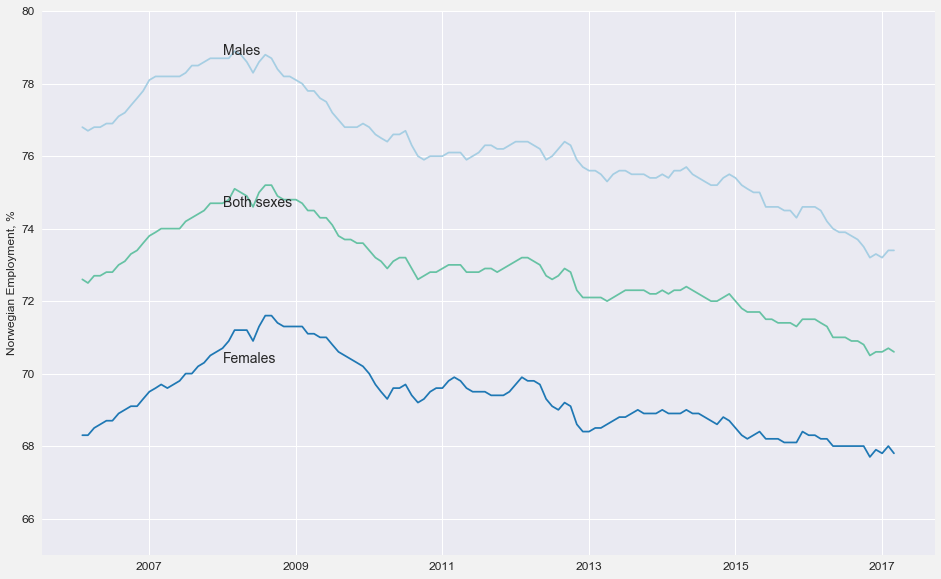

In [33]:
fig, ax = plt.subplots()
emp_by_sex = emp_perc_sa.groupby("sex")
for emp in emp_by_sex:
	ax.plot(emp[1].date, emp[1].value, label=emp[0])
	ax.annotate(emp[0], xy=(start, np.array(emp[1].value)[0]+2))
ax.set_ylabel("Norwegian Employment, %")
ax.set_ylim([65, 80])
fig.savefig("figures/employment.png", bbox_inches='tight')
plt.show()

### Bankruptcies

In [34]:
bankruptcies = pd.read_csv("https://data.ssb.no/api/v0/dataset/95265.csv?lang=en")
enter_bank = bankruptcies[bankruptcies.contents == 'Bankruptcies related to enterprises (excl. sole propriertorships)']
pers_bank = bankruptcies[bankruptcies.contents == 'Personal bankruptcies (incl. sole propriertorships)']


In [35]:
enter_bank.tail()

time                                           contents  \
1320  2017M01  Bankruptcies related to enterprises (excl. sol...   
1325  2017M02  Bankruptcies related to enterprises (excl. sol...   
1330  2017M03  Bankruptcies related to enterprises (excl. sol...   
1335  2017M04  Bankruptcies related to enterprises (excl. sol...   
1340  2017M05  Bankruptcies related to enterprises (excl. sol...   

     Bankruptcies, by time and contents  
1320                                269  
1325                                313  
1330                                353  
1335                                217  
1340                                 ..

In [39]:
#enter_bank = enter_bank[enter_bank.iloc[:,2]!=".."]
#pers_bank = pers_bank[pers_bank.iloc[:,2]!=".."]

def format_df(df):
	df.columns = ["time", "contents", "value"]
	df = df[["time", "value"]]
	df.loc[:, "time"] = df.time.apply(lambda x:  x.replace("M", ""))
	df.loc[:, "time"] = pd.to_datetime(df["time"], format="%Y%m")
	df.loc[:, "value"][df.value == ".."] =np.nan
	df.loc[:, "value"] = df.value.astype(float)
	return(df)

In [40]:
enter_bank.head()
enter_bank.tail()

time                                           contents value
1320  2017M01  Bankruptcies related to enterprises (excl. sol...   269
1325  2017M02  Bankruptcies related to enterprises (excl. sol...   313
1330  2017M03  Bankruptcies related to enterprises (excl. sol...   353
1335  2017M04  Bankruptcies related to enterprises (excl. sol...   217
1340  2017M05  Bankruptcies related to enterprises (excl. sol...    ..

In [41]:


enter_bank = format_df(enter_bank)
pers_bank = format_df(pers_bank)

start = datetime.strptime('01012000', '%d%m%Y')




In [42]:
from scipy.interpolate import UnivariateSpline

enter_bank = enter_bank[enter_bank.value.notnull()]
pers_bank = pers_bank[pers_bank.value.notnull()]
t = len(enter_bank.time)
T = [i for i in range(t)]
s_enter = UnivariateSpline(T, enter_bank.value, k=3, s=400000)
smooth_enter = s_enter(T)

In [43]:


s_pers = UnivariateSpline(T, pers_bank.value, k=3, s=200000)
smooth_person = s_pers(T)

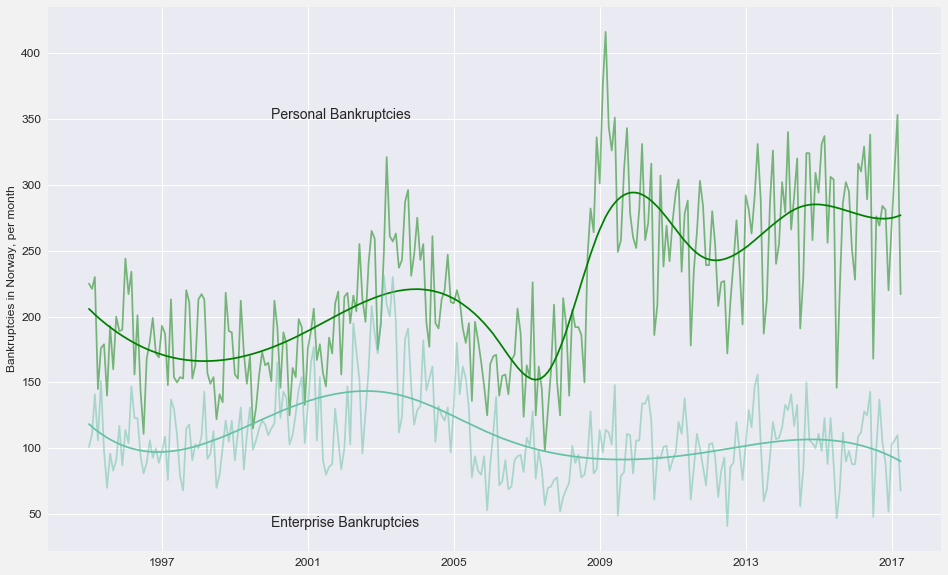

In [44]:
fig, ax = plt.subplots()
ax.plot(enter_bank.time, enter_bank.value, color="green", alpha=.5)
ax.plot(enter_bank.time, smooth_enter, color="green")
ax.plot(pers_bank.time, pers_bank.value, color='#66c2a4', alpha=.5)
ax.plot(pers_bank.time, smooth_person, color='#66c2a4')
ax.annotate('Personal Bankruptcies', xy=(start, 350))
ax.annotate('Enterprise Bankruptcies', xy=(start, 40))
ax.set_ylabel("Bankruptcies in Norway, per month")
fig.savefig("figures/bank_plot.png", bbox_inches='tight')
plt.show()

# Housing Prices

In [28]:
#house_prices = pd.read_csv("https://data.ssb.no/api/v0/dataset/1060.csv", sep=";", header=0, encoding = "cp865")


In [45]:
house_prices = pd.read_csv("https://data.ssb.no/api/v0/dataset/1060.csv", sep=";", header=0, encoding = "cp865")
house_prices.columns = ['region', 'type', 'time', 'variable','value']
time = house_prices.time.apply(lambda x: x.replace("K",""))
month = [str(int(t[-1])*3) for t in time]
year = [str(int(t[:-1])) for t in time]
house_prices["time"] = [x+y for x,y in zip(year, month)]
house_prices["time"] = pd.to_datetime(house_prices.time, format='%Y%m')
na_values = ["..", "."]
house_prices = house_prices[~house_prices.value.isin(na_values)]
house_prices["value"] = house_prices.value.apply(lambda x: float(x.replace(",", ".")))

all_houses = house_prices[house_prices.type=="00 Boliger i alt"]

start = datetime.strptime('01012005', '%d%m%Y')
end = datetime.strptime('01012015', '%d%m%Y')
all_houses = all_houses[all_houses.time>=start]


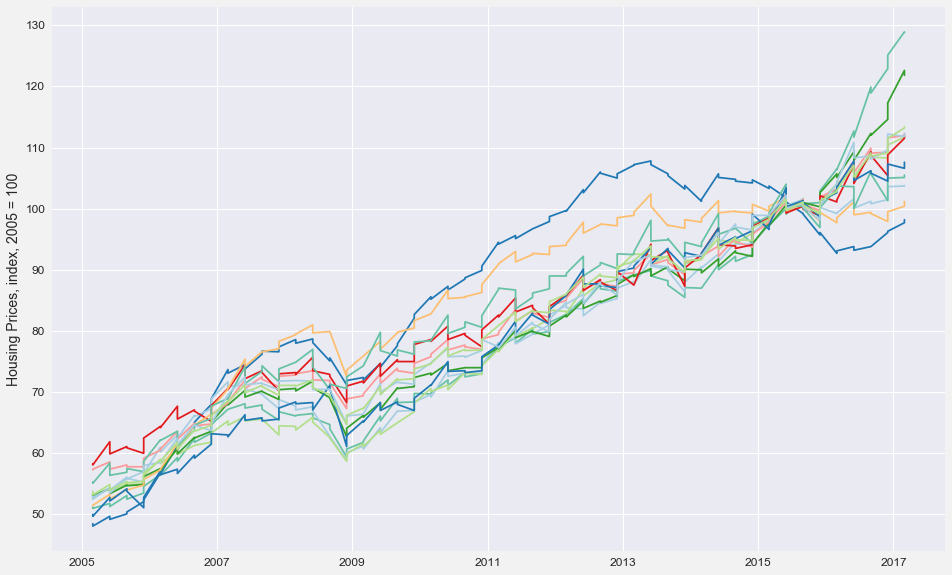

In [46]:
fig, ax = plt.subplots()
houses_by_region= all_houses.groupby("region")
for region in houses_by_region:
	ax.plot(region[1].time, region[1].value, label=region[0])
	#ax.legend()
	#n = len(region[1].value)
	#ax.annotate(region[0], xy=(end, region[1].value[0]) )
ax.set_ylabel("Housing Prices, index, 2005 = 100", size=14)
fig.savefig("figures/housing_prices.png", bbox_inches='tight')
plt.show()

In [47]:
names = []
prices_by_region = house_prices.groupby("region")
for region in prices_by_region:
	names.append(region[0])

new_names = ["Oslo with Baerum", "Stavanger", "Bergen", 
"Trondheim", "Akershus", "Southeast", "Hedmark and Oppland",
"Agder and Rogaland", "Westcoast", "Troendelag", "Northern Norway",
"Total"]

names_dict = dict(zip(names,new_names))

house_prices["region"] = house_prices.region.apply(lambda x: names_dict[x])

cities = new_names[0:4]

house_prices_cities = house_prices[house_prices.region.isin(cities)]
total_cities = house_prices_cities[house_prices_cities.type == "00 Boliger i alt"]
total_cities = total_cities[total_cities.variable == "Boligprisindeks, sesongjustert"]



In [48]:
start = datetime.strptime('01012005', '%d%m%Y')
end = datetime.strptime('01012015', '%d%m%Y')
total_cities = total_cities[total_cities.time>=start]


In [54]:
total_cities.dtypes

region              object
type                object
time        datetime64[ns]
variable            object
value              float64
dtype: object

In [60]:
houses_by_city= total_cities.groupby("region")

In [62]:
for city in houses_by_city:
    print(city[0])

Bergen
Oslo with Baerum
Stavanger
Trondheim


In [63]:
plt.plot?

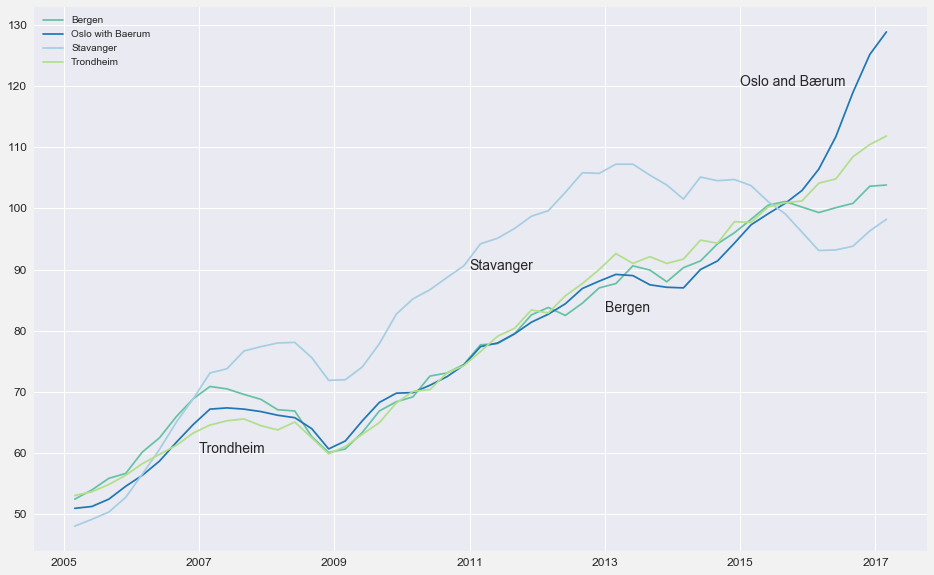

In [73]:
fig, ax = plt.subplots()
for city in houses_by_city:
	ax.plot(city[1].time, city[1].value, label=city[0])
	ax.legend()
	#n = len(region[1].value)
ax.annotate("Trondheim", xy=(datetime.strptime('01012007', '%d%m%Y'),60))
ax.annotate("Bergen", xy=(datetime.strptime('01012013', '%d%m%Y'),83))
ax.annotate("Stavanger", xy=(datetime.strptime('01012011', '%d%m%Y'),90))
ax.annotate("Oslo and Bærum", xy=(datetime.strptime('01012015', '%d%m%Y'),120))

#ax.set_ylabel("Housing Prices, index, SA 2005 = 100")
fig.savefig("figures/city_housing_prices.png", bbox_inches='tight')
plt.show()

#### Long term housing costs

In [74]:
xls_housing = pd.ExcelFile("http://www.norges-bank.no/WebDAV/hms/data/HousePrices.xlsx")
house_prices_l = xls_housing.parse('Table_A1', header=2)
house_prices_l.columns = ["year", "total", "oslo", "bergen", "trondheim", "kristiansand"]
house_prices_l = house_prices_l.iloc[15:,:]


In [75]:
house_prices_melt = pd.melt(house_prices_l, id_vars="year")
house_prices_melt["value"][house_prices_melt.value==" "] = np.nan
house_prices_melt["value"] =house_prices_melt.value.astype(float)


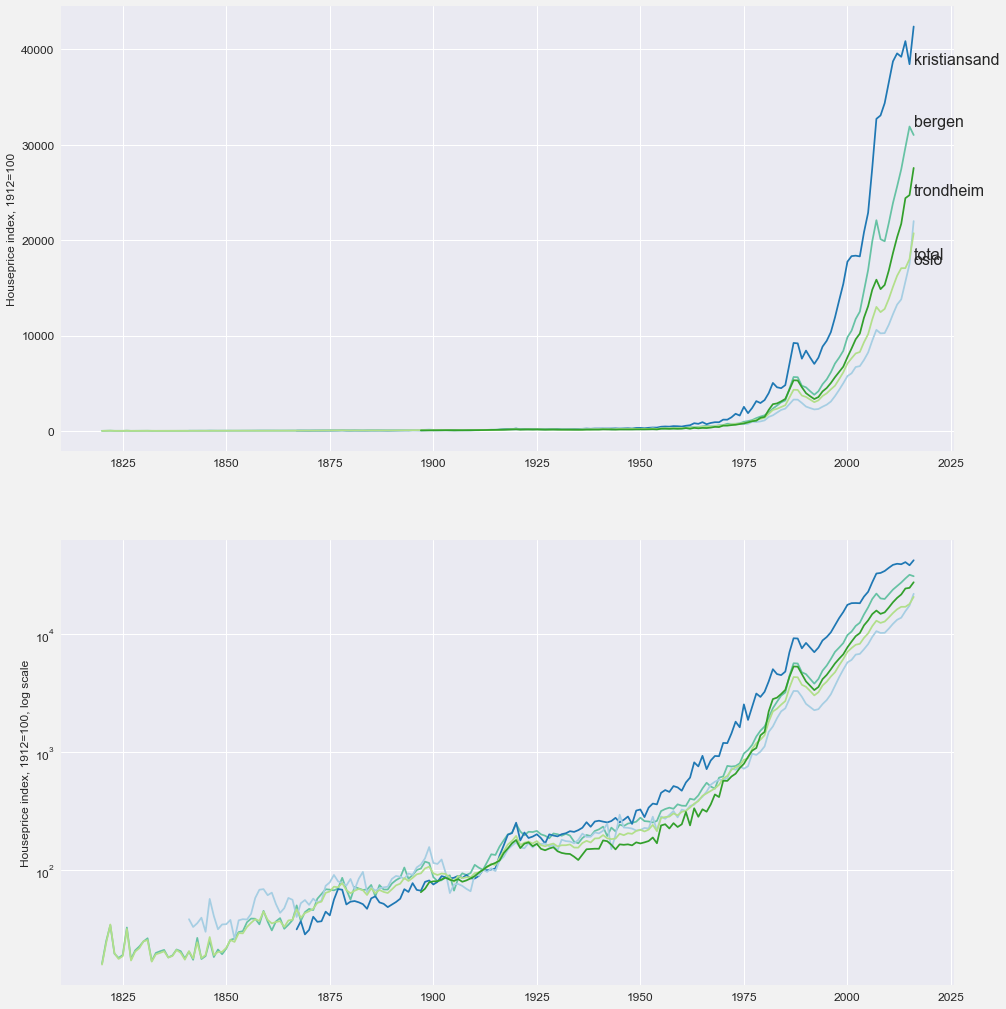

In [80]:
fig, ax = plt.subplots(2)
hp_by_city = house_prices_melt.groupby("variable")

for city_price in hp_by_city:
	ax[0].plot(city_price[1].year, city_price[1].value, label=city_price[0])
	ax[0].text(2016, np.array(city_price[1].value)[-2], city_price[0], size=16)
#ax.legend()
ax[0].set_ylabel("Houseprice index, 1912=100")

for city_price in hp_by_city:
	ax[1].plot(city_price[1].year, city_price[1].value, label=city_price[0])
ax[1].set_ylabel("Houseprice index, 1912=100, log scale")
ax[1].set_yscale('log')
fig.set_size_inches(16,18)
fig.savefig("figures/houseprices_long.png")
plt.show()

### Housing Cost Index

In [87]:
cost_index = pd.read_csv("http://data.ssb.no/api/v0/dataset/26944.csv?lang=en", sep=",", decimal=".", na_values=["..", "."])


In [88]:
cost_index.head()

type of employment     time                               contents  \
0           01 Total  1978M01                Construction cost index   
1           01 Total  1978M01  Change from previous month (per cent)   
2           01 Total  1978M01   Change from previous year (per cent)   
3           01 Total  1978M02                Construction cost index   
4           01 Total  1978M02  Change from previous month (per cent)   

   Construction cost index for residential buildings (2000=100), by type of employment, time and contents  
0                                               35.6                                                       
1                                                NaN                                                       
2                                                NaN                                                       
3                                               35.7                                                       
4                                                0.3

In [103]:
cost_index.columns = ['type', 'date', 'variable','index']
cost_index["date"] = pd.to_datetime(cost_index.date, format="%YM%m")

tot_cost_index = cost_index[cost_index.type=="01 Total"]
del tot_cost_index["type"]
tot_cost_index_w = tot_cost_index.pivot(index="date", columns = "variable", values="index")
tot_cost_index_w.head()

variable    Change from previous month (per cent)  \
date                                                
1978-01-01                                    NaN   
1978-02-01                                    0.3   
1978-03-01                                    0.3   
1978-04-01                                    0.6   
1978-05-01                                    0.0   

variable    Change from previous year (per cent)  Construction cost index  
date                                                                       
1978-01-01                                   NaN                     35.6  
1978-02-01                                   NaN                     35.7  
1978-03-01                                   NaN                     35.8  
1978-04-01                                   NaN                     36.0  
1978-05-01                                   NaN                     36.0

In [104]:
tot_cost_index_w.columns = ['% change, mom', '% change, yoy', 'cost index']
tot_cost_index_w.reset_index(inplace=True)

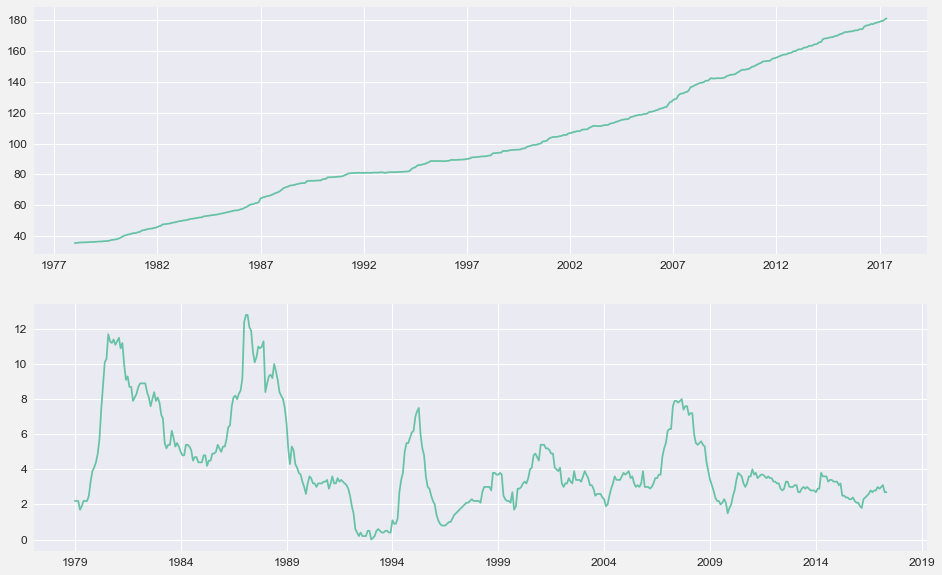

In [105]:
fig, ax = plt.subplots(2)
ax[0].plot(tot_cost_index_w.date, tot_cost_index_w["cost index"])
ax[1].plot(tot_cost_index_w.date, tot_cost_index_w["% change, yoy"])
plt.show()

In [106]:
tot_price_index = house_prices[house_prices.type == "00 Boliger i alt"]
tot_price_index = tot_price_index[tot_price_index.region =="Total"]
tot_price_index = tot_price_index[tot_price_index.variable == "Boligprisindeks, sesongjustert"]
#tot_price_index = tot_price_index[["time", "value"]]
#tot_price_index = tot_price_index.pivot(index="time", columns="region", values="value")


In [107]:
#tot_price_index.reset_index(inplace=True)


In [108]:

tot_price_index["% change, yoy"] = tot_price_index.value.pct_change(periods=4)*100
#tot_price_index.reset_index(inplace=True)


In [109]:
tot_cost_index_w.head()

date  % change, mom  % change, yoy  cost index
0 1978-01-01            NaN            NaN        35.6
1 1978-02-01            0.3            NaN        35.7
2 1978-03-01            0.3            NaN        35.8
3 1978-04-01            0.6            NaN        36.0
4 1978-05-01            0.0            NaN        36.0

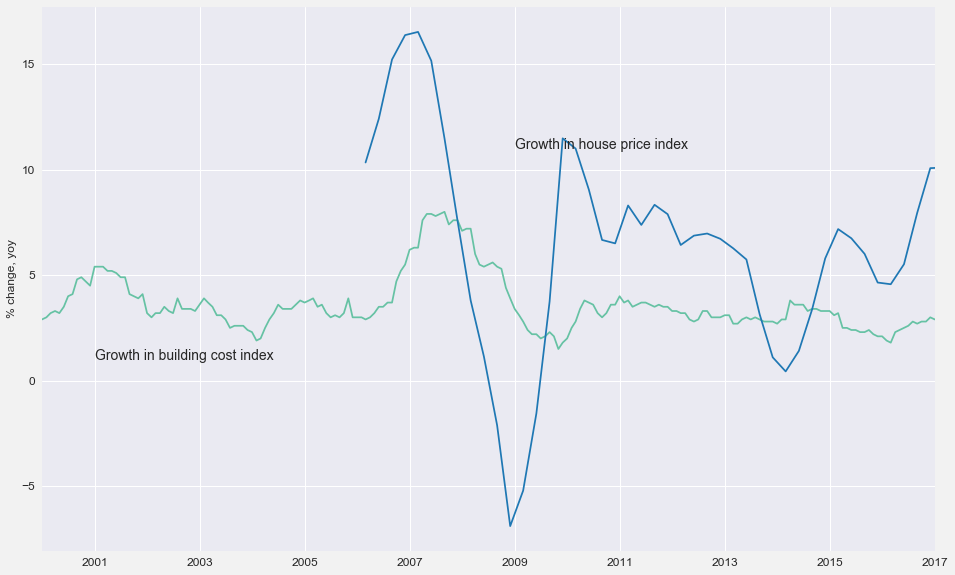

In [110]:

fig, ax = plt.subplots()
ax.plot(tot_cost_index_w.date, tot_cost_index_w["% change, yoy"])
ax.plot(tot_price_index.time, tot_price_index["% change, yoy"])
ax.set_xlim([pd.to_datetime("2000-01-01"), pd.to_datetime("2017-01-01")])
ax.set_ylabel("% change, yoy")
ax.annotate("Growth in house price index", xy=(datetime.strptime('01012009', '%d%m%Y'),11))
ax.annotate("Growth in building cost index", xy=(datetime.strptime('01012001', '%d%m%Y'),1))
fig.savefig("figures/building_cost.png")
plt.show()

### New housing starts, principalities with major cities

In [112]:
bygging = pd.read_csv("http://data.ssb.no/api/v0/dataset/26025.csv?lang=no", sep=";", header=0, decimal=",", encoding = "cp865")
bygging["region"]=bygging.region.astype('category')

fylker = ['Oestfold', 'Akershus', 'Oslo', 'Hedmark', 'Oppland',
       'Buskerud', 'Vestfold', 'Telemark', 'Aust-Agder',
       'Vest-Agder', 'Rogaland', 'Hordaland', 'Sogn og Fjordane',
       'Moere og Romsdal', 'Soer-Troendelag', 'Nord-Troendelag',
       'Nordland', 'Troms', 'Finnmark',
       'Svalbard']

bygging["region"] = bygging.region.cat.rename_categories(fylker)

bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
bygging.statistikkvariabel.cat.categories
variabler = ['Boliger under arbeid', 'Fullfoert bruksareal (1 000 m2)',
       'Fullfoerte boliger', 'Igangsatt bruksareal (1 000 m2)',
       'Igangsatte boliger', 'Under arbeid, bruksareal (1 000 m�)']
bygging["statistikkvariabel"] = bygging.statistikkvariabel.cat.rename_categories(variabler)
bygging.rename(columns={"Boligbygg, etter region, statistikkvariabel og tid": "boligbygging"}, inplace=True)
bygging["tid"] = pd.to_datetime(bygging.tid, format="%YM%m")
bygging["boligbygging"]=bygging.boligbygging.astype(float)


In [113]:
igangsatte = bygging[bygging.statistikkvariabel == "Igangsatte boliger"]
rel_fylker = ['Oslo', 'Rogaland', 'Hordaland',  'Soer-Troendelag']
igangsatte = igangsatte[bygging.region.isin(rel_fylker)]
igangsatte["region"] = igangsatte.region.astype('str')


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


#### Smoothing

In [114]:
from scipy.interpolate import UnivariateSpline

igangsatte = igangsatte[igangsatte.boligbygging.notnull()]

#bygging_by_city = igangsatte.groupby("region")
Oslo = igangsatte[igangsatte.region=="Oslo"]
Hordaland = igangsatte[igangsatte.region=="Hordaland"]
Rogaland = igangsatte[igangsatte.region =="Rogaland"]
Soer_Troendelag = igangsatte[igangsatte.region=="Soer-Troendelag"]

#smooth the city data
d = {"date":igangsatte["tid"][igangsatte.region=="Oslo"]}
smooth_data = pd.DataFrame(data=d)
t = len(Oslo.tid)
T = [i for i in range(t)]

s_city = UnivariateSpline(T, Oslo.boligbygging, k=3, s=6000000)
smooth_data["Oslo"] = s_city(T)

s_city = UnivariateSpline(T, Hordaland.boligbygging, k=3, s=2000000)
smooth_data["Hordaland"] = s_city(T)

s_city = UnivariateSpline(T, Rogaland.boligbygging, k=3, s=2000000)
smooth_data["Rogaland"] = s_city(T)

s_city = UnivariateSpline(T, Soer_Troendelag.boligbygging, k=3, s=2000000)
smooth_data["Soer-Troendelag"] = s_city(T)

smooth_data_l = pd.melt(smooth_data, id_vars = "date")

smooth_by_city = smooth_data_l.groupby("variable")


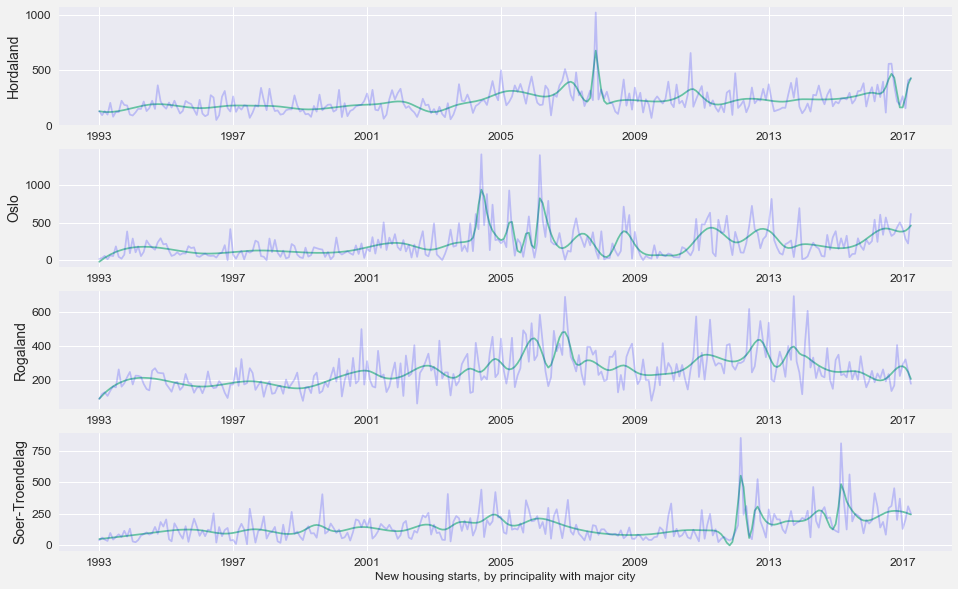

In [115]:
bygging_by_city = igangsatte.groupby("region")
fig, ax = plt.subplots(4)
for a, city in enumerate(smooth_by_city):
	ax[a].plot(city[1].date, city[1].value)
	ax[a].set_ylabel(city[0], size=14)

for a, city in enumerate(bygging_by_city):
	ax[a].plot(city[1].tid, city[1].boligbygging, alpha=.2, color="blue")
	#n = len(region[1].value)
#ax.set_ylabel("Number of new dwellings", size=14)
ax[3].set_xlabel("New housing starts, by principality with major city")
fig.savefig("figures/city_new_housing_starts.png")
plt.show()

### Entire Country

In [117]:
bygging = pd.read_csv("http://data.ssb.no/api/v0/dataset/95146.csv?lang=no", sep=";", header=0, decimal=",", encoding = "cp865")
bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
bygging.statistikkvariabel.cat.categories
variabler = ['Boliger under arbeid', 'Fullfoert bruksareal (1 000 m2)',
       'Fullfoerte boliger', 'Igangsatt bruksareal (1 000 m2)',
       'Igangsatte boliger', 'Under arbeid, bruksareal (1 000 m�)']
bygging["statistikkvariabel"] = bygging.statistikkvariabel.cat.rename_categories(variabler)
bygging.rename(columns={"Boligbygg, etter region, statistikkvariabel og tid": "boligbygging"}, inplace=True)
bygging["tid"] = pd.to_datetime(bygging.tid, format="%YM%m")
bygging["boligbygging"]=bygging.boligbygging.astype(float)

igangsatte = bygging[bygging.statistikkvariabel == "Igangsatte boliger"]
t = len(igangsatte.tid)
T = [i for i in range(t)]

s_igangsatte = UnivariateSpline(T, igangsatte.boligbygging, k=3, s=50000000)
smooth_igangsatte = s_igangsatte(T)


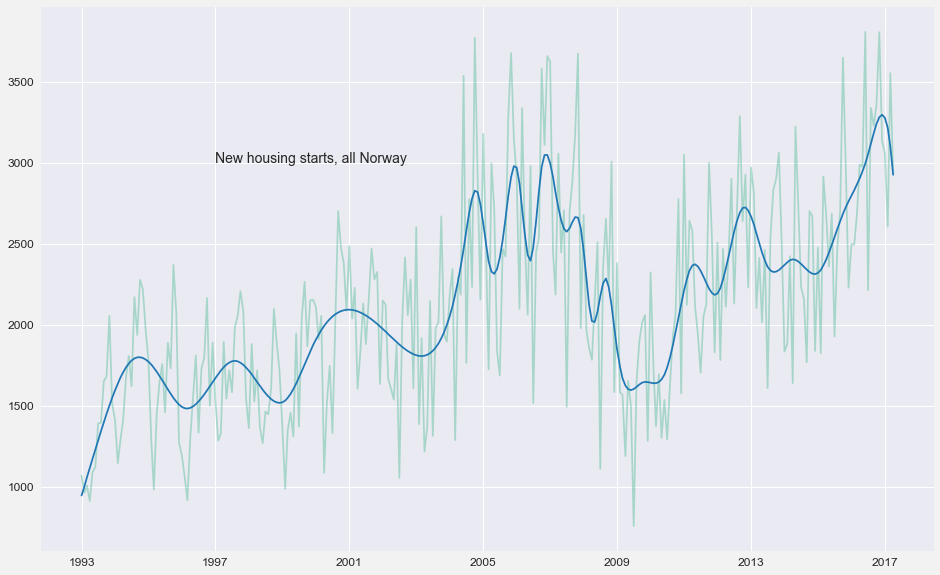

In [118]:
fig, ax = plt.subplots()
ax.plot(igangsatte.tid, igangsatte.boligbygging, alpha=.5)
ax.plot(igangsatte.tid, smooth_igangsatte)
ax.annotate("New housing starts, all Norway", xy=(datetime.strptime('01011997', '%d%m%Y'),3000))
fig.savefig("figures/new_housing_starts.png")
plt.show()

## Credit and Debt

In [119]:
#credit
#debt_json = pd.read_json("https://data.ssb.no/api/v0/dataset/62264.json?lang=no")

debt = pd.read_csv("https://data.ssb.no/api/v0/dataset/62264.csv?lang=no", sep=";", na_values = [".", ".."], encoding = "cp865")
debt.columns = ['currency', 'sector', 'credit_source', 'time', 'variable','value']

debt["time"] = convert_datetime(debt.time)
debt["value"] = debt.value.astype(float)
debt["value"] = debt["value"]/1000

by_source = debt.groupby("credit_source")
for source in by_source:
	print(source[0])

by_sector = debt.groupby("sector")
for sect in by_sector:
	print(sect[0])

total_sources = debt[debt.credit_source=="LTOT Kredittkilder i alt"]
total_sources = total_sources[total_sources.currency=="00 I alt"]




L201 Statlige lσneinstitutter
L202 Utlσn fra banker
L203 Utlσn fra kredittforetak
L204 Utlσn fra finansieringsselskaper
L206 Utlσn fra livsforsikringsselskaper
L207 Utlσn fra skadeforsikringsselskaper
L209 Utlσn fra pensjonskasser
L210 Obligasjonsgjeld
L211 Sertifikatgjeld
L212 Utlσn fra andre kilder
LTOT Kredittkilder i alt
Kred01 Publikum
Kred02 Kommuneforvaltningen
Kred03 Ikke-finansielle foretak
Kred04 Husholdninger mv.


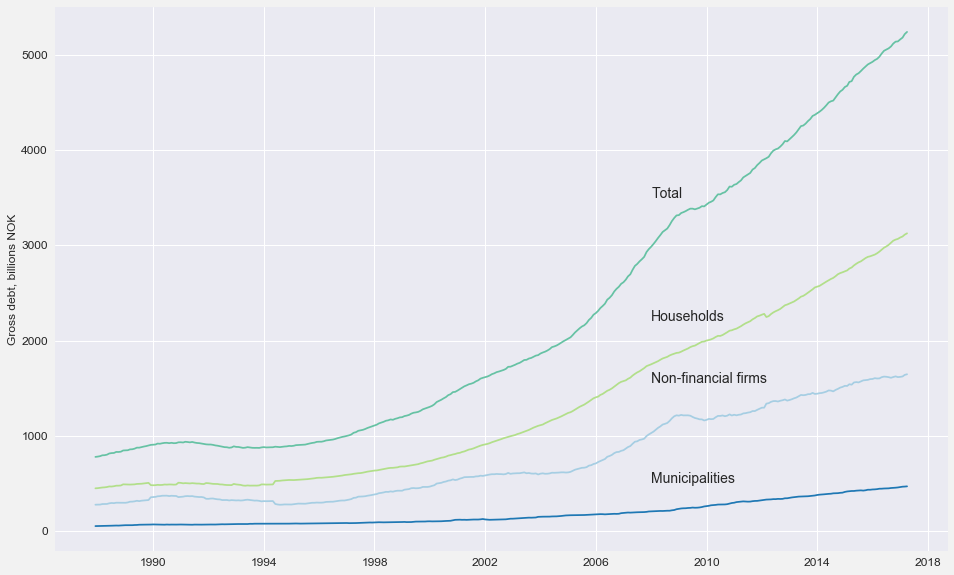

In [120]:
start = datetime.strptime('01012008', '%d%m%Y')
fig, ax = plt.subplots()
tot_by_sector = total_sources.groupby("sector")
for sect in tot_by_sector:
	ax.plot(sect[1].time, sect[1].value, label=sect[0])
#ax.legend()
ax.annotate("Total", xy=(yearmonth("200801"),3500))
ax.annotate("Households", xy=(yearmonth("200801"), 2200))
ax.annotate("Non-financial firms", xy=(yearmonth("200801"), 1550))
ax.annotate("Municipalities", xy=(yearmonth("200801"), 500))
ax.set_ylabel("Gross debt, billions NOK")
fig.savefig("figures/debt_by_sector.png")
plt.show()


###   household debt by source

In [ ]:
debt = debt[debt.value.notnull()]
debt = debt[debt.value!=0]

In [145]:
household = debt[debt.sector=="Kred04 Husholdninger mv."]
household = household[household.currency =="00 I alt"]
household.credit_source.unique()

array(['LTOT Kredittkilder i alt', 'L202 Utlσn fra banker',
       'L201 Statlige lσneinstitutter', 'L203 Utlσn fra kredittforetak',
       'L204 Utlσn fra finansieringsselskaper',
       'L206 Utlσn fra livsforsikringsselskaper',
       'L207 Utlσn fra skadeforsikringsselskaper',
       'L209 Utlσn fra pensjonskasser', 'L210 Obligasjonsgjeld',
       'L211 Sertifikatgjeld', 'L212 Utlσn fra andre kilder'], dtype=object)

In [146]:



source_inc = ['L202 Utlσn fra banker',
       'L201 Statlige lσneinstitutter', 'L203 Utlσn fra kredittforetak']

household = household[household.credit_source.isin(source_inc)]


In [147]:

household_by_source = household.groupby("credit_source")


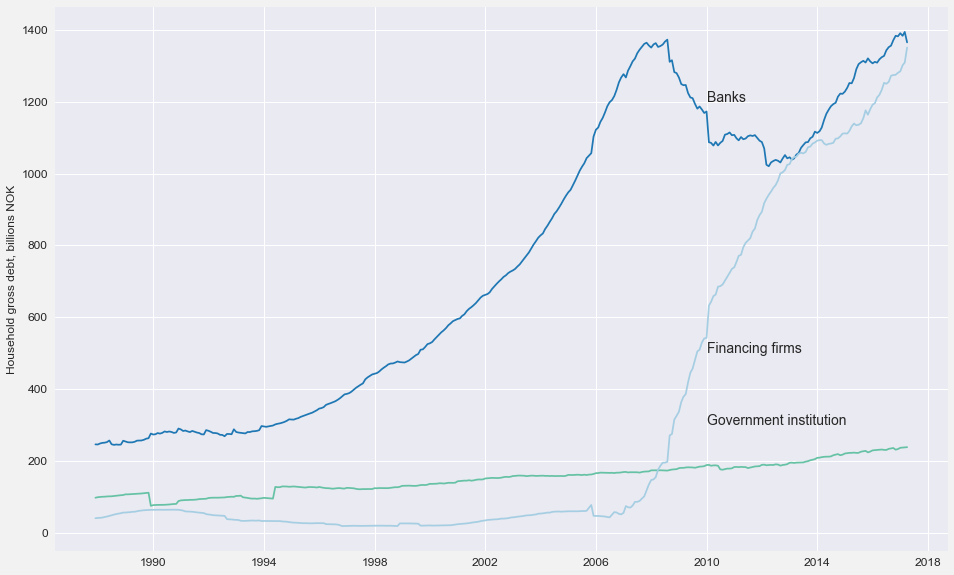

In [148]:
fig, ax = plt.subplots()

for source in household_by_source:
	ax.plot(source[1].time, source[1].value, label=source[0])
#ax.legend()
#ax.annotate("Total", xy=(yearmonth("201001"),2300))
ax.annotate("Banks", xy=(yearmonth("201001"), 1200))
ax.annotate("Financing firms", xy=(yearmonth("201001"), 500))
ax.annotate("Government institution", xy=(yearmonth("201001"), 300))
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Household gross debt, billions NOK")
fig.savefig("figures/household_debt_by_source.png")
plt.show()

#### by currency

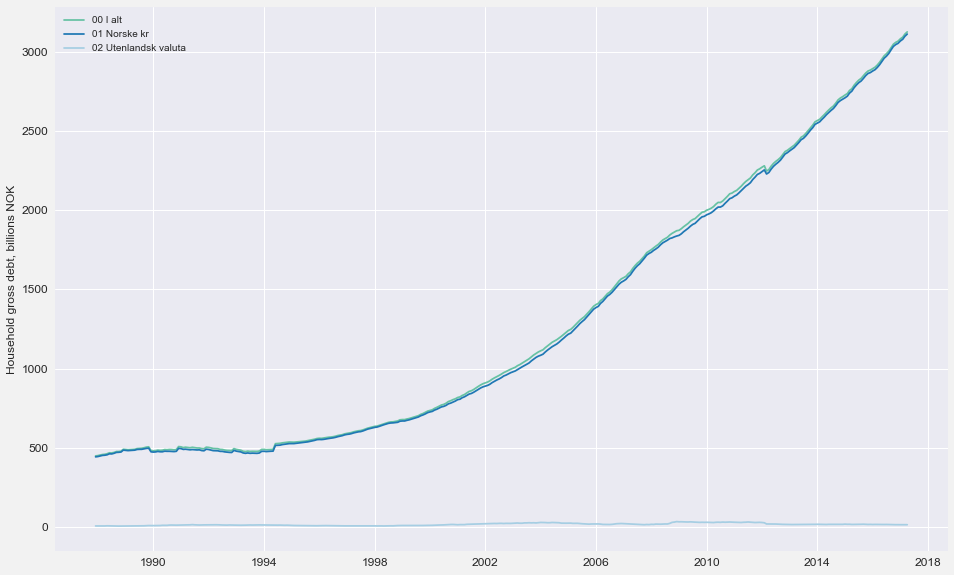

In [149]:
household = debt[debt.sector=="Kred04 Husholdninger mv."]
household = household[household.credit_source == "LTOT Kredittkilder i alt"]

fig, ax = plt.subplots()
household_by_currency = household.groupby("currency")
for currency in household_by_currency:
	ax.plot(currency[1].time, currency[1].value, label=currency[0])
ax.legend()
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Household gross debt, billions NOK")
plt.show()

#### Non-financial firms

In [150]:
firms = debt[debt.sector=="Kred03 Ikke-finansielle foretak"]
firms = firms[firms.currency =="00 I alt"]

firms_inc = ["L201 Statlige l�neinstitutter",
"L202 Banker",
"L203 Kredittforetak",
"L204 Finansieringsselskaper",
"L206 Livsforsikringsselskaper",
"L207 Skadeforsikringsselskaper",
"L209 Pensjonskasser",
"L210 Obligasjonsgjeld",
"L211 Sertifikatgjeld",
"L212 Andre kilder",
"LTOT Kredittkilder i alt"]

#firms = firms[firms.credit_source.isin(source_inc)]



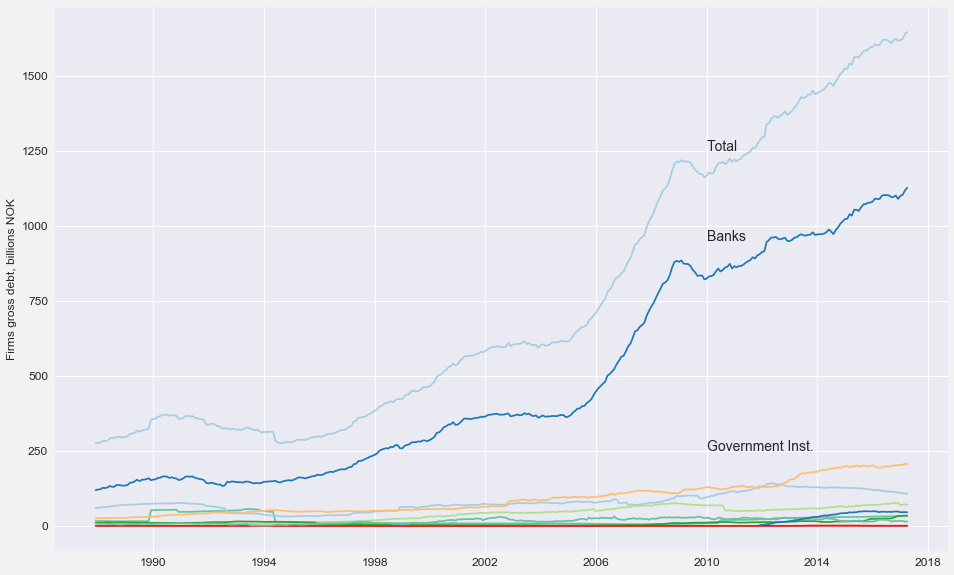

In [151]:
fig, ax = plt.subplots()
firms_by_source = firms.groupby("credit_source")
for source in firms_by_source:
	ax.plot(source[1].time, source[1].value, label=source[0])
#ax.legend()
ax.annotate("Total", xy=(yearmonth("201001"),1250))
ax.annotate("Banks", xy=(yearmonth("201001"), 950))
ax.annotate("Government Inst.", xy=(yearmonth("201001"), 250))
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Firms gross debt, billions NOK")
fig.savefig("figures/firm_debt_by_source.png")
plt.show()

#### Interest rates

In [152]:
ir=pd.read_csv("http://www.norges-bank.no/WebDAV/stat/en/renter/v2/renter_mnd.csv")

ir["DATES"] = [datetime.strptime(d, "%b-%y") for d in ir.DATES]

ir.columns = ['date', 'folio_nom', 'res_nom', 'dlaan_nom',
	   'statskvl_3m_eff','statskvl_6m_eff', 'statskvl_9m_eff', 
	   'statskvl_12m_eff','statsobl_3y_eff', 'statsobl_5y_eff', 
	   'statsobl_10y_eff', 'nowa_rt','nowa_vl']



include = ['date','dlaan_nom', 'statskvl_3m_eff', 'statskvl_12m_eff', 'statsobl_10y_eff']
ir = ir[include]



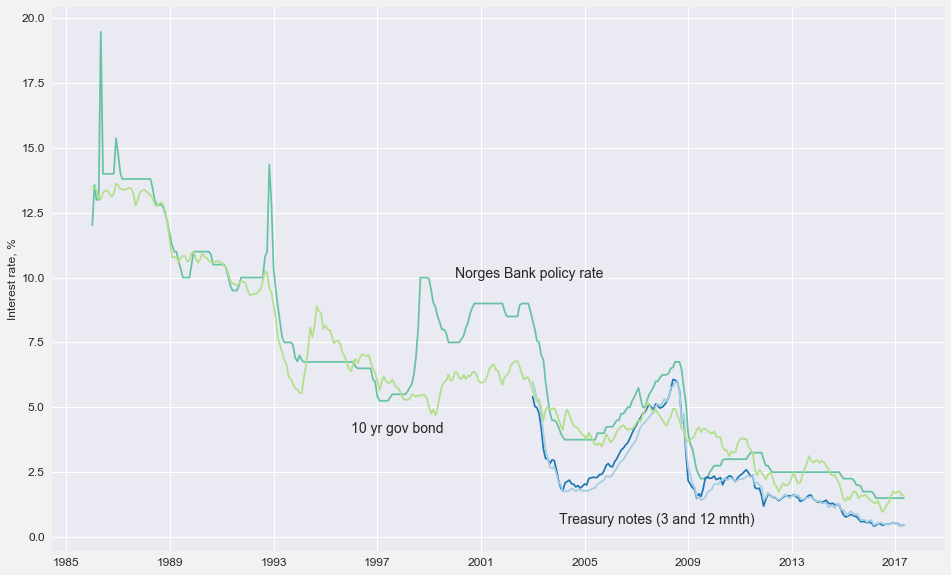

In [153]:
ir_long = pd.melt(ir, id_vars="date")
ir_long["value"][ir_long.value=="ND"] = np.nan
ir_long["value"] = ir_long.value.astype(float)

fig, ax = plt.subplots()
for r in ir_long.groupby("variable"):
	ax.plot(r[1].date, r[1].value, label=r[0])
ax.text(yearmonth("200001"), 10, "Norges Bank policy rate")
ax.text(yearmonth("200401"), .5, "Treasury notes (3 and 12 mnth)")
ax.text(yearmonth("199601"), 4, "10 yr gov bond")
ax.set_ylabel("Interest rate, %")
fig.savefig("figures/interest_rates.png")
plt.show()

#### Historical interest rates and inflation

In [154]:
long_ir = pd.ExcelFile("http://www.norges-bank.no/WebDAV/hms/data/ShortTerm_IR.xlsx")
real_ir = long_ir.parse('p2c7_table_7B1',header=2)
real_ir = real_ir.iloc[:-13,:]
real_ir.Year = real_ir.Year.astype(float)

rir_include = ['Year', 'Real marginal rate', 'Real deposit rate', 'Real loans rate',
       'Real bond yield']

inflation_include = ['Year', 'Inflation rate', 'Smoothed inflation rate']

inflation = real_ir[inflation_include]
real_ir = real_ir[rir_include]



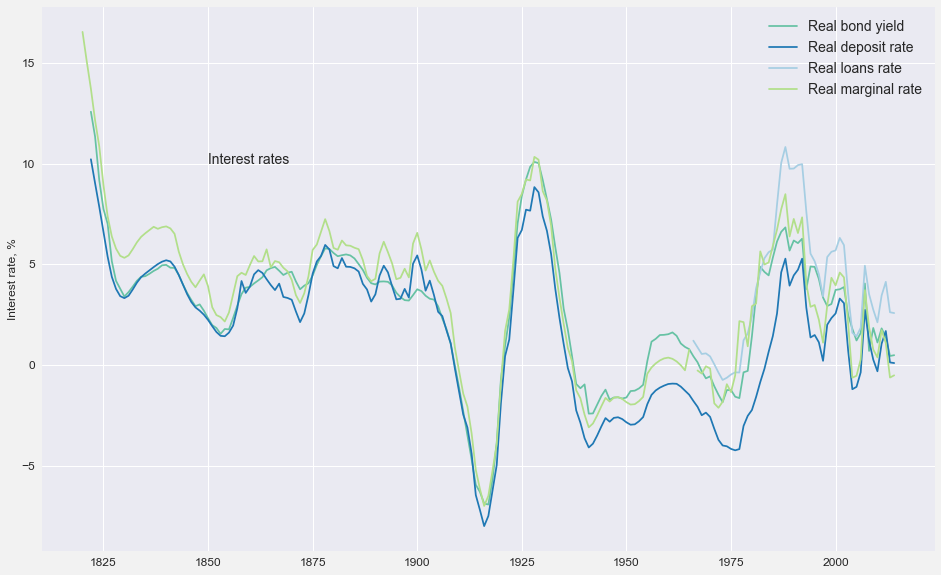

In [155]:
real_ir_long = pd.melt(real_ir, id_vars="Year")
fig, ax = plt.subplots()
for r in real_ir_long.groupby("variable"):
	ax.plot(r[1].Year, r[1].value, label=r[0])
ax.legend(fontsize=14)
ax.text(1850, 10, "Interest rates")
ax.set_ylabel("Interest rate, %")
fig.savefig("figures/ir_long.png")
plt.show()



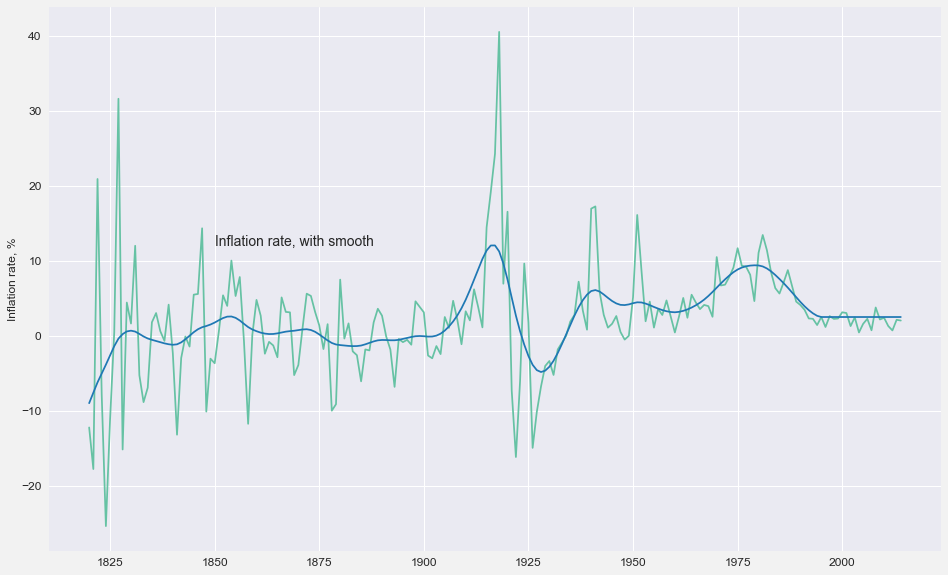

In [156]:
inflation_long = pd.melt(inflation, id_vars="Year")
fig, ax = plt.subplots()
for i in inflation_long.groupby("variable"):
	ax.plot(i[1].Year, i[1].value, label=i[0])
ax.text(1850, 12, "Inflation rate, with smooth")
ax.set_ylabel("Inflation rate, %")
# ax.legend()
fig.savefig("figures/long_inflation_rate")
plt.show()

## Oil and Gas

#### brent oil price


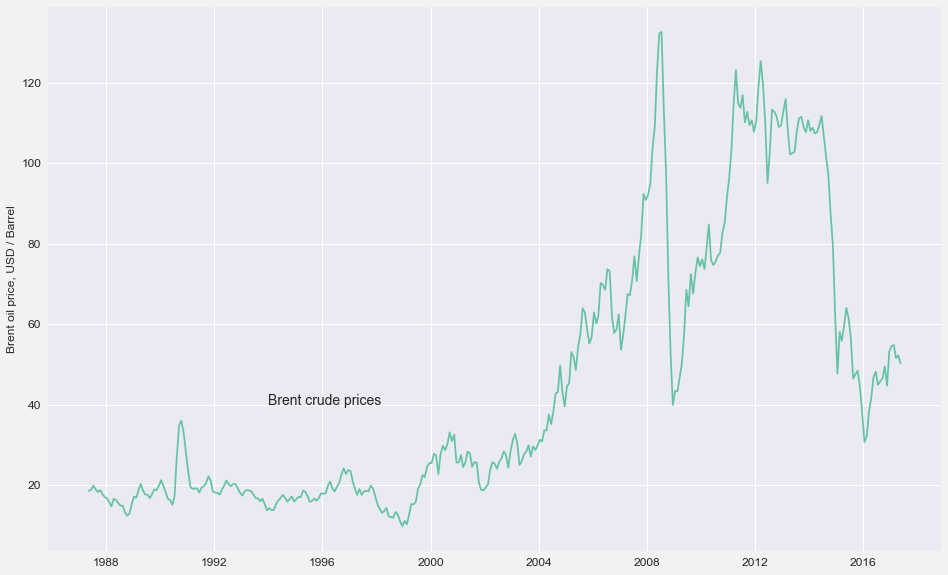

In [157]:
#prices from eia
xls = pd.ExcelFile("http://www.eia.gov/dnav/pet/hist_xls/RBRTEm.xls")
brent_prices = xls.parse('Data 1', header=2)

brent_prices.columns = ["date", "brent_price"]
brent_prices["date"] = pd.to_datetime(brent_prices.date, format="%Y-%m-%d")

fig, ax = plt.subplots()
ax.plot(brent_prices.date, brent_prices.brent_price, label="Brent Crude Price, $/Barrel")
ax.text(yearmonth("199401"), 40, "Brent crude prices")
#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Brent oil price, USD / Barrel")
fig.savefig("figures/brent_prices.png")
plt.show()

In [158]:
#prices from NPD
tot_prod=pd.read_csv("http://factpages.npd.no/ReportServer?/FactPages/TableView/field_production_totalt_NCS_month__DisplayAllRows&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=158.37.94.56&CultureCode=nb-no")
tot_prod.columns = ['﻿prod_year', 'prod_month', 
'oil_millm3', 'gas_billsm3',
'ngl_millsm3', 'condensate_millsm3',
'oe_millsm3', 'water_millsm3']

tot_prod["date"] = pd.to_datetime(tot_prod.loc[:, '﻿prod_year'].astype(str) + tot_prod.loc[:,"prod_month"].astype(str),
	format = "%Y%m")

prod_include = ['date', 'oil_millm3', 'gas_billsm3','water_millsm3']
tot_prod = tot_prod[prod_include]

tot_prod_long = pd.melt(tot_prod, id_vars =["date"])
tot_prod_long["value"] = tot_prod_long.value.astype(float)
tot_prod_long = tot_prod_long[tot_prod_long.value!=0]

smoothed = tot_prod_long.groupby("variable")["value"].transform(smooth_series)
tot_prod_long["smoothed"] = smoothed


//anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


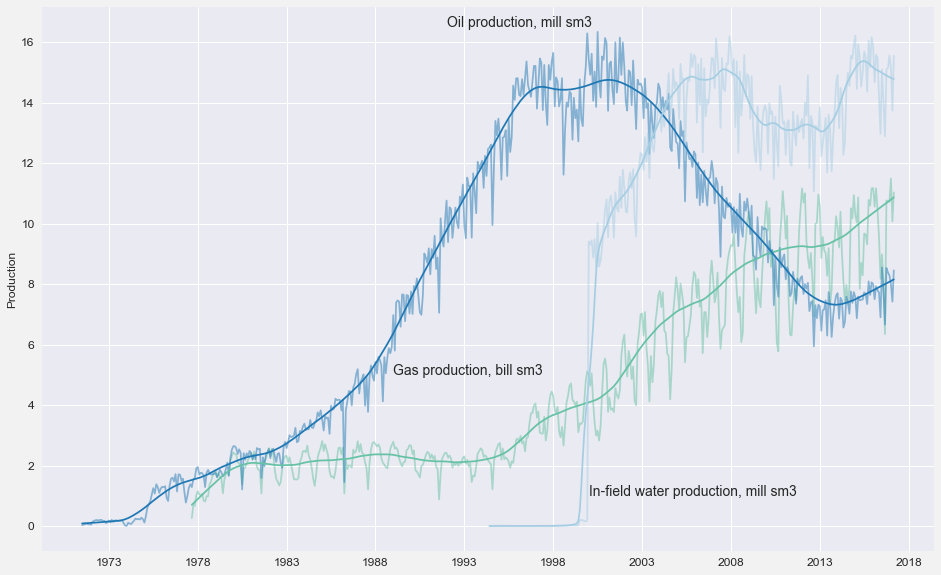

In [159]:
fig, ax = plt.subplots()
prod_by_liquid = tot_prod_long.groupby("variable")
for liquid in prod_by_liquid:
	ax.plot(liquid[1].date, liquid[1].value, label=liquid[0], alpha=.5)
plt.gca().set_color_cycle(None)
for liquid in prod_by_liquid:
	ax.plot(liquid[1].date, liquid[1].smoothed)
#ax.legend()
ax.text(yearmonth("199201"), 16.5, "Oil production, mill sm3")
ax.text(yearmonth("198901"), 5, "Gas production, bill sm3")
ax.text(yearmonth("200001"), 1, "In-field water production, mill sm3")
ax.set_ylabel("Production")
fig.savefig("figures/oil_gas_production.png")
plt.show()

#### Investment in oil and gas fields

In [160]:
investments=pd.read_csv("http://factpages.npd.no/ReportServer?/FactPages/TableView/field_investment_yearly&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=158.37.94.112&CultureCode=en")

tot_investments = investments.groupby("prfYear")['prfInvestmentsMillNOK'].aggregate(sum)
tot_investments = tot_investments.reset_index()
tot_investments.columns = ["year", "invest_millNOK"]
tot_investments = tot_investments[tot_investments.invest_millNOK!=0]




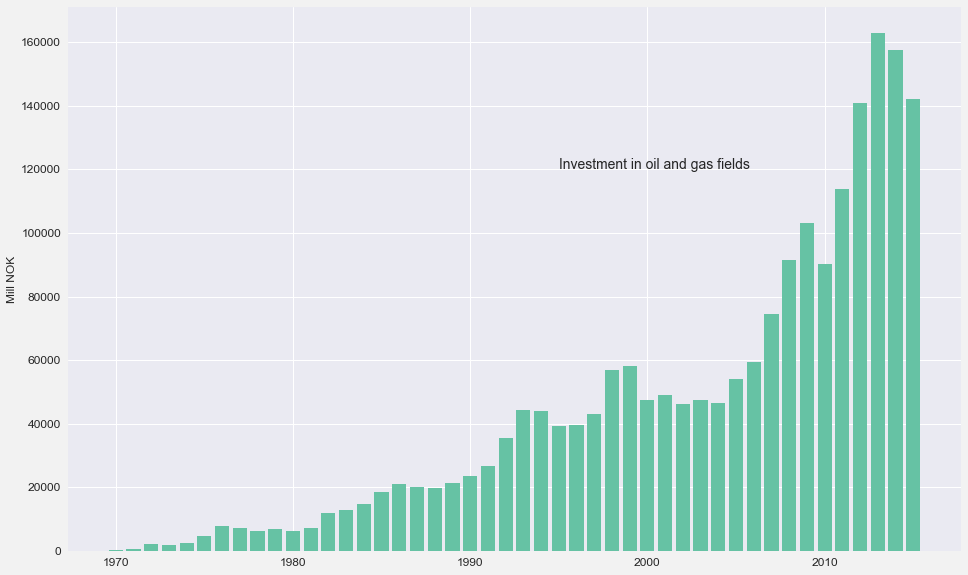

In [161]:
fig, ax = plt.subplots()
ax.bar(tot_investments.year, tot_investments.invest_millNOK, color="#66c2a4")
ax.set_ylabel("Mill NOK")
ax.text(1995, 120000, "Investment in oil and gas fields")
fig.savefig("figures/oil_investment.png", bbox_inches='tight')
plt.show()

# Wages and earnings

In [162]:
wages = pd.ExcelFile("http://www.norges-bank.no/WebDAV/hms/data/Wages_Ind.xlsx")
tot_wages = wages.parse('Table_total', header=2)
ind_wages = wages.parse('Table_6A4', header=3)

#total wages
tot_wages = tot_wages.iloc[:-12,:]
tot_wages["Year"][tot_wages.Year=="2014*"] = "2014"
tot_wages["Year"] = tot_wages.Year.astype(int)

tot_wages_long = pd.melt(tot_wages, id_vars="Year")



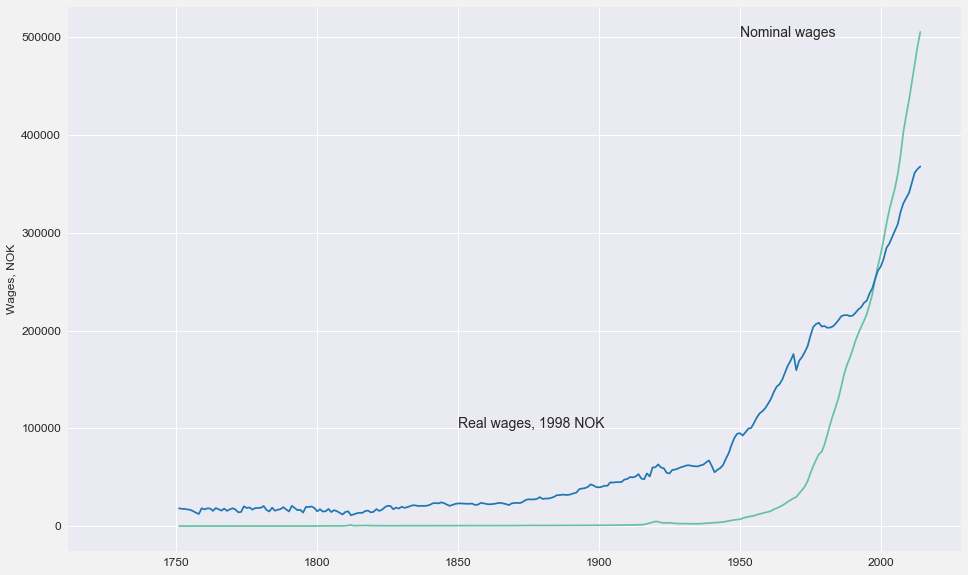

In [163]:
fig, ax = plt.subplots()
for wage in tot_wages_long.groupby("variable"):
	ax.plot(wage[1].Year, wage[1].value, label=wage[0])
ax.text(1850, 100000, "Real wages, 1998 NOK") 
ax.text(1950, 500000, "Nominal wages")
#ax.legend()
ax.set_ylabel("Wages, NOK")
fig.savefig("figures/tot_wages.png")
plt.show()

## Demographics

#### Population, by age grou

In [170]:
fm5aar=pd.read_csv("http://data.ssb.no/api/v0/dataset/65195.csv?lang=en", sep=",", encoding = "cp865")
fm5aar.head()

age           sex  time contents  Persons by age, sex and time
0  F00-04 0-4 years  0 Both sexes  1846  Persons                        170316
1  F00-04 0-4 years  0 Both sexes  1847  Persons                        171133
2  F00-04 0-4 years  0 Both sexes  1848  Persons                        170015
3  F00-04 0-4 years  0 Both sexes  1849  Persons                        170392
4  F00-04 0-4 years  0 Both sexes  1850  Persons                        176726

In [171]:
fm5aar.columns = ['alder', 'kjoenn', 'tid', 'statistikkvariabel',
       'personer']
fm5aar["alder"] = [i.split(" ")[1] for i in fm5aar.alder]


fm5aar.head()

alder        kjoenn   tid statistikkvariabel  personer
0   0-4  0 Both sexes  1846            Persons    170316
1   0-4  0 Both sexes  1847            Persons    171133
2   0-4  0 Both sexes  1848            Persons    170015
3   0-4  0 Both sexes  1849            Persons    170392
4   0-4  0 Both sexes  1850            Persons    176726

In [172]:
totalt = fm5aar[fm5aar.kjoenn == "0 Both sexes"]

totalt_fm5 = totalt[["tid", "alder", "personer"]]
totalt_fm5_w = totalt_fm5.pivot(index='tid', columns='alder', values='personer')
totalt_fm5_w.columns.values
totalt_fm5_w = totalt_fm5_w[['0-4','5-9', '10-14','15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49',  '50-54', '55-59', '60-64', '65-69',
       '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100']]

Y = np.array(totalt_fm5_w)

dates = totalt_fm5.tid.unique()



In [173]:
fm5_2015 = totalt_fm5[totalt_fm5.tid==2015]
fm5_2015["annotate_y"] = fm5_2015.personer.cumsum()
fm5_2015["annotate_y"] = [i-100000 for i in fm5_2015.annotate_y]
fm5_2015.head()

marks = ['0-4',  '10-14',  '20-24',  '30-34', 
       '40-44',  '50-54', '60-64','70-74',
        '80-84',  '100']

fm5_2015 = fm5_2015[fm5_2015.alder.isin(marks)]
fm5_2015["annotate_y"].iloc[-1] = fm5_2015["annotate_y"].iloc[-1] + 120000

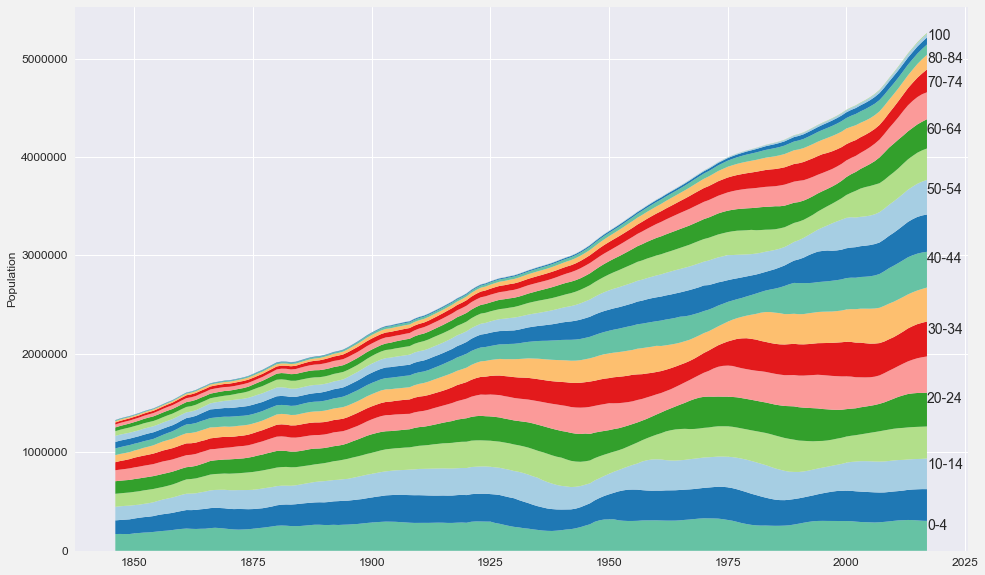

In [174]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for fm5 in fm5_2015.groupby("alder"):
    ax.annotate(fm5[0], xy=(2017, np.array(fm5[1].annotate_y)[0]))
ax.set_ylabel("Population")
fig.savefig("figures/pop_by_age.png")
plt.show()

#### Immigration

In [73]:
pop = pd.read_csv("http://data.ssb.no/api/v0/dataset/49626.csv?lang=no", sep=";")

pop.columns = ["region", "year", "variable", "value"]
pop = pop[["year", "variable", "value"]]
pop_tot = pop[pop.variable=="Folkemengde"]
pop_tot = pop_tot[["year", "value"]]
pop_tot.columns = ["year", "pop_tot"]

innvandring = pd.read_csv("http://data.ssb.no/api/v0/dataset/48651.csv?lang=no", sep=";")
innvandring.columns = ['region', 'kjoenn', 'landbakgrunn', 'year', 'statistikkvariabel',
       'innvandrer']
innvandring = innvandring[['kjoenn', 'landbakgrunn', 'year',
       'innvandrer']]
innvandring = innvandring.merge(pop_tot, on="year", how ="left")
innvandring["pros_innvan"] = innvandring["innvandrer"]/innvandring["pop_tot"]*100

total = innvandring.groupby(["year", "landbakgrunn"])["pros_innvan"].aggregate(sum)
total = total.reset_index()
total_w = total.pivot(index="year", columns="landbakgrunn", values="pros_innvan")
Y = np.array(total_w)
x=total.year.unique()

In [74]:
annotate_y = pd.DataFrame()
annotate_y["labels"] = ["Europe", "Africa", "Asia w Turkey", "North America", "South America", "Oseania"]
annotate_y["y"] = [6,8, 11, 12.5, 13, 13.5]

In [75]:
for ant in annotate_y.iterrows():
    print(ant[1]["labels"])

Europe
Africa
Asia w Turkey
North America
South America
Oseania


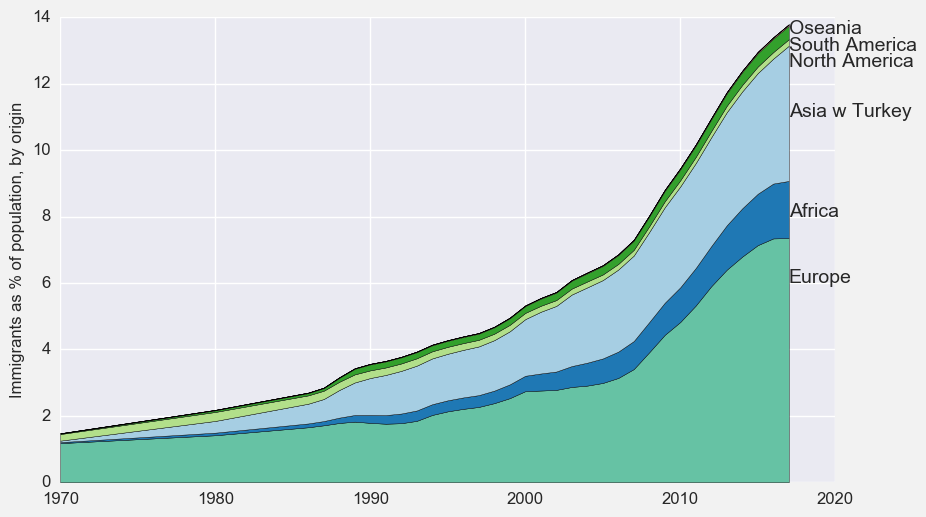

In [76]:

fig, ax = plt.subplots()
ax.stackplot(x, Y.T)
for ant in annotate_y.iterrows():
    ax.annotate(ant[1]["labels"], xy=(2017, ant[1]["y"]))
ax.set_ylabel("Immigrants as % of population, by origin")
fig.savefig("figures/imig_pros.png")
plt.show()

#### Migration to the cities

In [176]:
fylker = ['Oestfold', 'Akershus', 'Oslo', 'Hedmark', 'Oppland',
       'Buskerud', 'Vestfold', 'Telemark', 'Aust-Agder',
       'Vest-Agder', 'Rogaland', 'Hordaland',
       'Bergen', 'Sogn og Fjordane', 'Moere og Romsdal',
       'Sør-Trøndelag', 'Nord-Troendelag', 'Nordland',
       'Troms', 'Finnmark']


#Look at population
population = pd.read_csv("http://data.ssb.no/api/v0/dataset/49623.csv?lang=no", sep=";", encoding = "cp865")
population["tid"] = pd.to_datetime(population.tid, format="%Y")

population.region = population.region.astype('category')

population["region"] = population.region.cat.rename_categories(fylker)
population = population[population.region.isin(['Oslo', 'Rogaland', 'Hordaland','Sør-Trøndelag'])]

population.columns = ["region", "tid", "statistikkvariabel", "population"]
population["population"] = population.population.astype(float)
population.region = population.region.astype(str)

innflyttinger = population[population.statistikkvariabel.isin(["Innflyttinger"])]
del innflyttinger["statistikkvariabel"]
innflyttinger.columns = ['region', 'tid', 'innflyttinger']
innflyttinger["utflyttinger"] = population.population[population.statistikkvariabel=="Utflyttinger"].values
innflyttinger["net_migration"] = innflyttinger["innflyttinger"] - innflyttinger["utflyttinger"]
folkemengde = population[population.statistikkvariabel=="Folkemengde"]


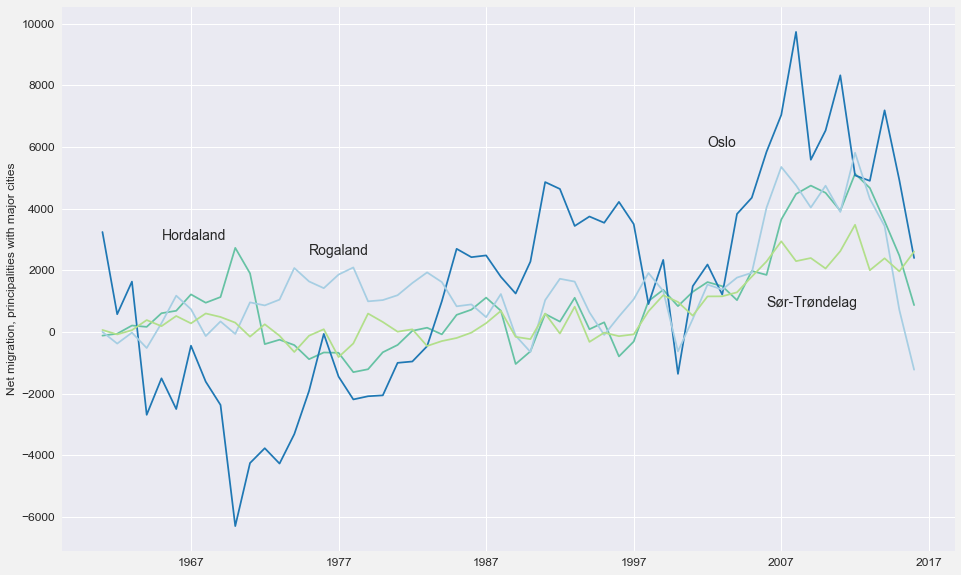

In [177]:

innflyttinger_by_city = innflyttinger.groupby("region")
fig, ax = plt.subplots()
for city in innflyttinger_by_city:
	ax.plot(city[1].tid.iloc[10:-1], city[1].net_migration.iloc[10:-1], label=city[0])
ax.text(pd.to_datetime(2002, format="%Y"), 6000, "Oslo")
ax.text(pd.to_datetime(1975, format="%Y"), 2500, "Rogaland")
ax.text(pd.to_datetime(2006, format="%Y"), 800, "Sør-Trøndelag")
ax.text(pd.to_datetime(1965, format="%Y"), 3000, "Hordaland")
ax.set_ylabel("Net migration, principalities with major cities")
fig.savefig("figures/net_migration_cities.png")
plt.show()



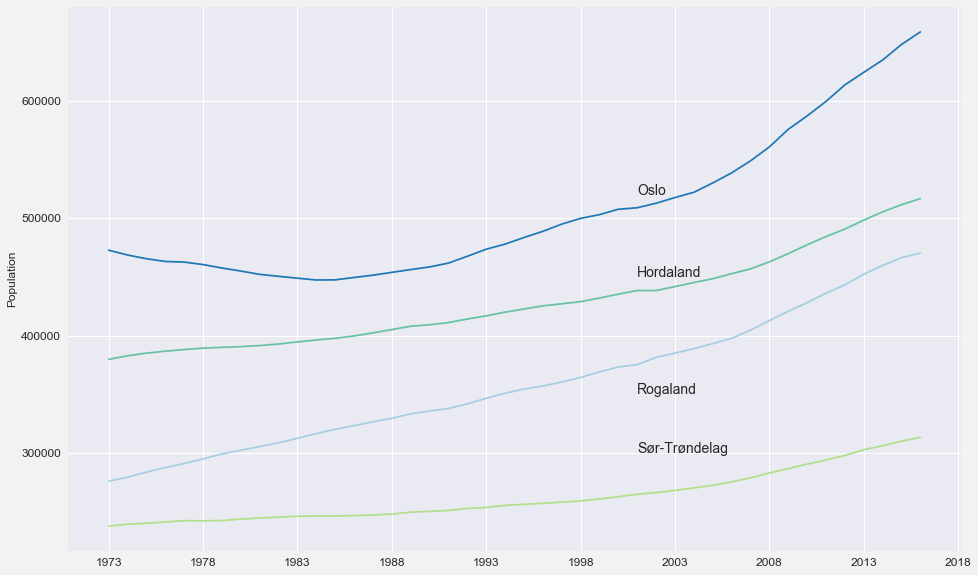

In [178]:
folkemengde_by_city = folkemengde.groupby("region")
fig, ax = plt.subplots()
for city in folkemengde_by_city:
	ax.plot(city[1].tid.iloc[22:-1], city[1].population.iloc[22:-1], label=city[0])
ax.text(pd.to_datetime(2001, format="%Y"), 520000, "Oslo")
ax.text(pd.to_datetime(2001, format="%Y"), 350000, "Rogaland")
ax.text(pd.to_datetime(2001, format="%Y"), 300000, "Sør-Trøndelag")
ax.text(pd.to_datetime(2001, format="%Y"), 450000, "Hordaland")
ax.set_ylabel("Population")
fig.savefig("figures/pop_cities.png")

plt.show()

In [179]:
folkemengde.head()

region        tid statistikkvariabel  population
670   Oslo 1951-01-01        Folkemengde    434365.0
675   Oslo 1952-01-01        Folkemengde    437184.0
680   Oslo 1953-01-01        Folkemengde    440674.0
685   Oslo 1954-01-01        Folkemengde    444041.0
690   Oslo 1955-01-01        Folkemengde    447064.0


#### Import and export

In [81]:
#laks_eksport = ("http://data.ssb.no/api/v0/dataset/1122?lang=no", sep=";")

## National Accounts

In [181]:
NR=pd.read_csv("http://data.ssb.no/api/v0/dataset/59022.csv", 
         sep=";", decimal=",", na_values = [".", ".."], encoding = "cp865")
NR.columns = ["variabel", "kvartal", "enhet", "verdi"]

NR["kvartal"]  = convert_datetime(NR.kvartal) #fra zoo

#sesong justert
NRSA = NR[NR.enhet == "Faste 2014-priser, sesongjustert (mill. kr)"]

#enhet "Faste 2013-priser, sesongjustert (mill. kr)"
NRSA = NRSA[["variabel", "kvartal", "verdi"]]

#use tidyr to split
kateg = NRSA.variabel.str.split('.', n=1).str[0]
variabel = NRSA.variabel.str.split(' ', n=1).str[1]

NRSA["kateg"] = kateg
NRSA["variabel"] = variabel


In [182]:
NRSA.head()

variabel    kvartal   verdi kateg
1  Konsum i husholdninger og ideelle organisasjoner 2000-03-01  205440   koh
3  Konsum i husholdninger og ideelle organisasjoner 2000-06-01  208892   koh
5  Konsum i husholdninger og ideelle organisasjoner 2000-09-01  208886   koh
7  Konsum i husholdninger og ideelle organisasjoner 2000-12-01  207632   koh
9  Konsum i husholdninger og ideelle organisasjoner 2001-03-01  210089   koh

In [183]:
#investering

investering = NRSA[NRSA.kateg =="bif"]
del investering["kateg"]

# invest_stack.reset_index(inplace=True)

# invest_stack = pd.melt(invest_stack, id_vars = "kvartal")

investering.head()
invest_w = investering.pivot(index='kvartal', columns='variabel', values='verdi')

invest_var = ['Total Investment', 'Fixed Assets',
       'Mainland Norway',
       'Foreign Shipping',
       'Extraction',
       'Mainland Norway, excl public sector',
       'Housing',
       'Private Sector',
       'Public Sector',
       'Other services',
       'Other production',
       'Industry and Mining',
       'Extraction Services']

invest_w.columns = invest_var

invest_stack = invest_w[["Extraction", "Housing", "Public Sector", "Total Investment"]]
invest_stack["Other"] = invest_stack["Total Investment"] - invest_stack[["Extraction", "Housing", "Public Sector"]].sum(axis=1)

del invest_stack["Total Investment"]


In [184]:
invest_stack.columns.values

array(['Extraction', 'Housing', 'Public Sector', 'Other'], dtype=object)

In [185]:
annotate = pd.DataFrame()
annotate["labels"] = ['Oil and Gas Extraction', 'Housing', 'Public Sector', 'Other']
annotate["Y"] = [10000, 50000, 80000, 120000]

Y = np.array(invest_stack)

dates = investering.kvartal.unique()


annotate

labels       Y
0  Oil and Gas Extraction   10000
1                 Housing   50000
2           Public Sector   80000
3                   Other  120000

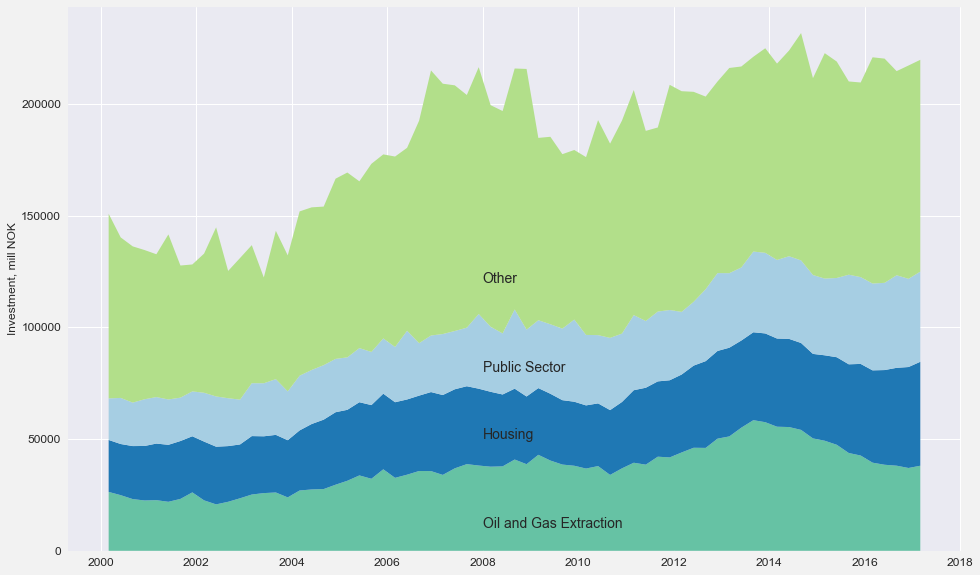

In [186]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
ax.set_ylabel("Investment, mill NOK")
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
fig.savefig("figures/na_investments.png")
plt.show()


### Eksport

In [187]:
eksport = NRSA[NRSA.kateg == "eks"]
del eksport["kateg"]
eksport_w = eksport.pivot(index='kvartal', columns='variabel', values='verdi')
eksport_w.columns =['Total', 'Oil and Gas',
       'Ships and Platforms', 'Services',
       'Traditional Commodities']
eksport_stack = eksport_w
del eksport_stack["Total"]


Y = np.array(eksport_stack)

dates = eksport_stack.index.values



In [188]:
annotate = pd.DataFrame()
annotate["labels"] = ['Oil and Gas', 'Ships and Platforms', 'Services', 'Other Commodities']
annotate["Y"] = [80000, 160000, 200000, 270000]


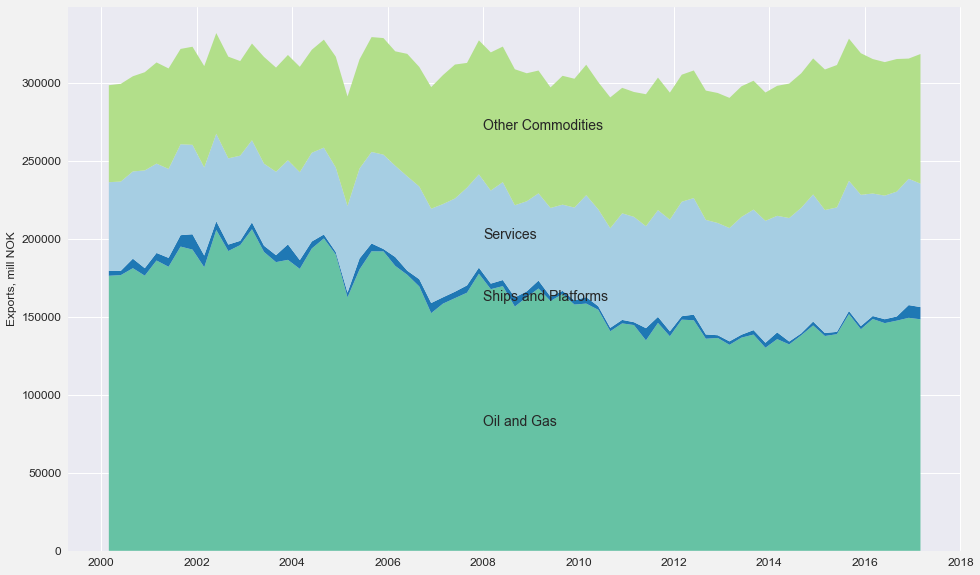

In [189]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Exports, mill NOK")
fig.savefig("figures/na_eksports.png")
plt.show()

### Imports 

In [190]:
imports =  NRSA[NRSA.kateg == "imp"]

del imports["kateg"]
imports_w = imports.pivot(index='kvartal', columns='variabel', values='verdi')
imports_w.columns =['Total', 'Oil and Gas',
       'Ships and Platforms', 'Services',
       'Other Goods']
       
imports_stack = imports_w
del imports_stack["Total"]


Y = np.array(imports_stack)

dates = imports_stack.index.values



In [191]:
annotate = pd.DataFrame()
annotate["labels"] = ['Oil and Gas',
       'Ships and Platforms', 'Services',
       'Other Goods']
annotate["Y"] = [5000, 17000, 50000, 150000]


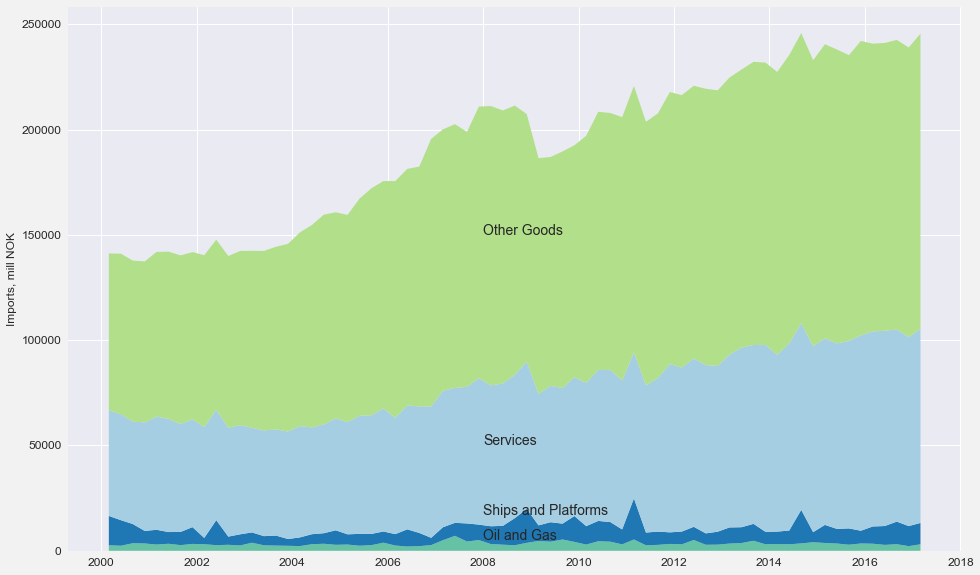

In [192]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Imports, mill NOK")
fig.savefig("figures/na_imports.png")
plt.show()

In [193]:
pkon = NRSA[NRSA.kateg=="koh"]

del pkon["kateg"]
pkon_w = pkon.pivot(index='kvartal', columns='variabel', values='verdi')
pkon_w.columns =['Household and Nonprofit',
       'Household', 'Household Foreign Consumption',
       'Services', 'Foreigners Consumption in Norway', 'Goods']

pkon_stack = pkon_w[['Services', 'Goods']]


Y = np.array(pkon_stack)

dates = pkon_stack.index.values



In [194]:
annotate = pd.DataFrame()
annotate["labels"] = ["Services", "Goods"]
annotate["Y"] = [50000, 150000]


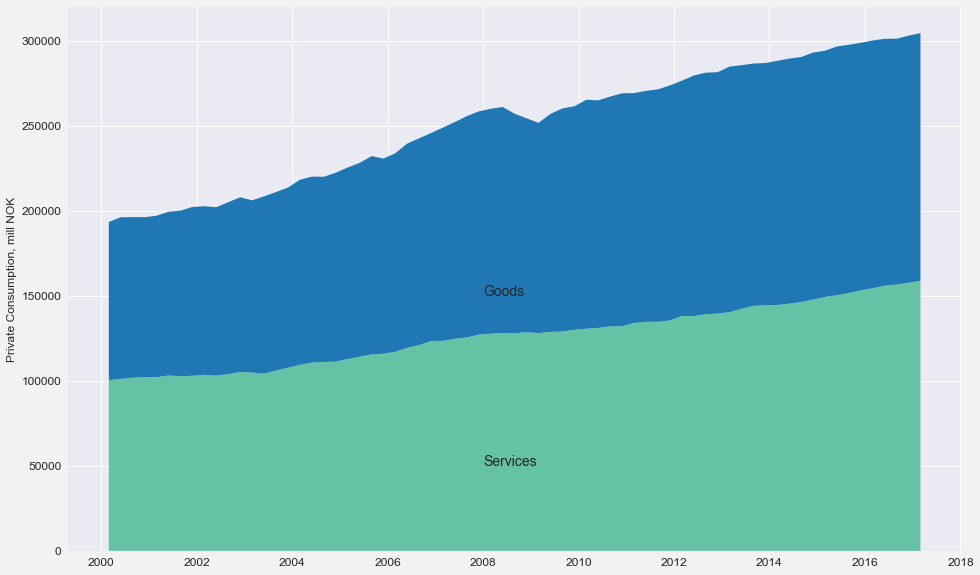

In [195]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Private Consumption, mill NOK")
fig.savefig("figures/na_privconsumption.png")
plt.show()

### Public sector 

In [196]:
okon = NRSA[NRSA.kateg=="koo"]

del okon["kateg"]
okon_w = okon.pivot(index='kvartal', columns='variabel', values='verdi')
okon_w.columns =['Public sector', 
	  'Principalities',
       'State',
       'State, Military',
       'State, Civil']

okon_stack = okon_w[['Principalities',
       'State, Military',
       'State, Civil']]

Y = np.array(okon_stack)

dates = okon_stack.index.values



In [197]:
annotate = pd.DataFrame()
annotate["labels"] = ['Principalities',
       'State, Military',
       'State, Civil']
annotate["Y"] = [40000, 90000, 120000]


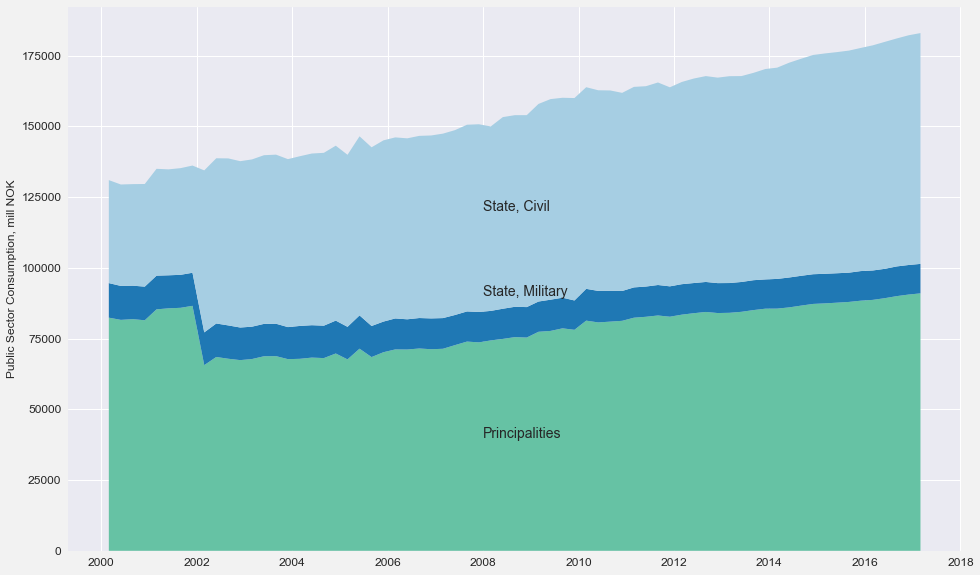

In [198]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Public Sector Consumption, mill NOK")
fig.savefig("figures/na_publicconsumption.png")
plt.show()

### As share of GDP

In [199]:
bnp = NRSA[NRSA.kateg == "bnpb"]
bnp = bnp[bnp.variabel=='Bruttonasjonalprodukt, markedsverdi']
bnp = bnp[["kvartal", "verdi"]]
bnp.columns = ["kvartal", "bnp"]

okon_stack.reset_index(inplace=True)
okon_perc = okon_stack.merge(bnp, how="left", on="kvartal")
okon_perc["State, Military, %GDP"] = okon_perc["State, Military"]/okon_perc["bnp"]*100
okon_perc["State, Civil, %GDP"] = okon_perc["State, Civil"]/okon_perc["bnp"]*100
okon_perc["Principalities, %GDP"] = okon_perc["Principalities"]/okon_perc["bnp"]*100
okon_perc = okon_perc[['kvartal', 'State, Military, %GDP', 'Principalities, %GDP',
       'State, Civil, %GDP']]

okon_l = pd.melt(okon_perc,id_vars="kvartal")



In [200]:
annotate2 = pd.DataFrame()
annotate2["labels"] = ['State, Military',
       'State, Civil',
       'Principalities']
annotate2["Y"] = [2, 8, 11]


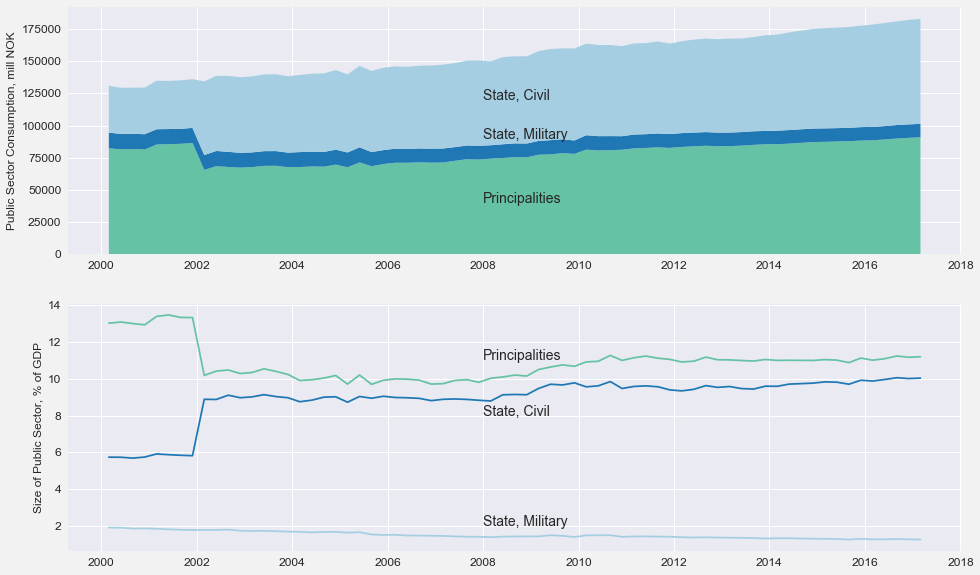

In [202]:
fig, ax = plt.subplots(2)
ax[0].stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax[0].annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax[0].set_ylabel("Public Sector Consumption, mill NOK")

start = datetime.strptime('01012008', '%d%m%Y')
okon_by_sector = okon_l.groupby("variable")
for sector in okon_by_sector:
	ax[1].plot(sector[1].kvartal, sector[1].value, label=sector[0])
ax[1].set_ylabel("Size of Public Sector, % of GDP")
for ant in annotate2.iterrows():
    ax[1].annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
#fig.set_size_inches(12,15)
fig.savefig("figures/na_publicsector.png")
plt.show()

### Regionalt: Trondheim

#### house prices

In [205]:
trondheim_house_prices = total_cities.loc[total_cities.region == "Trondheim",]
trondheim_house_prices = trondheim_house_prices[["time", "value"]]
trondheim_house_prices.columns = ["date", "boligpriser"]

#percent change
trondheim_house_prices["perc_chang_priser"] = trondheim_house_prices.boligpriser.diff(periods=4)/trondheim_house_prices.boligpriser*100

trondheim_house_prices.head()


date  boligpriser  perc_chang_priser
3337 2005-03-01         53.1                NaN
3339 2005-06-01         53.7                NaN
3341 2005-09-01         54.9                NaN
3343 2005-12-01         56.4                NaN
3345 2006-03-01         58.3           8.919383

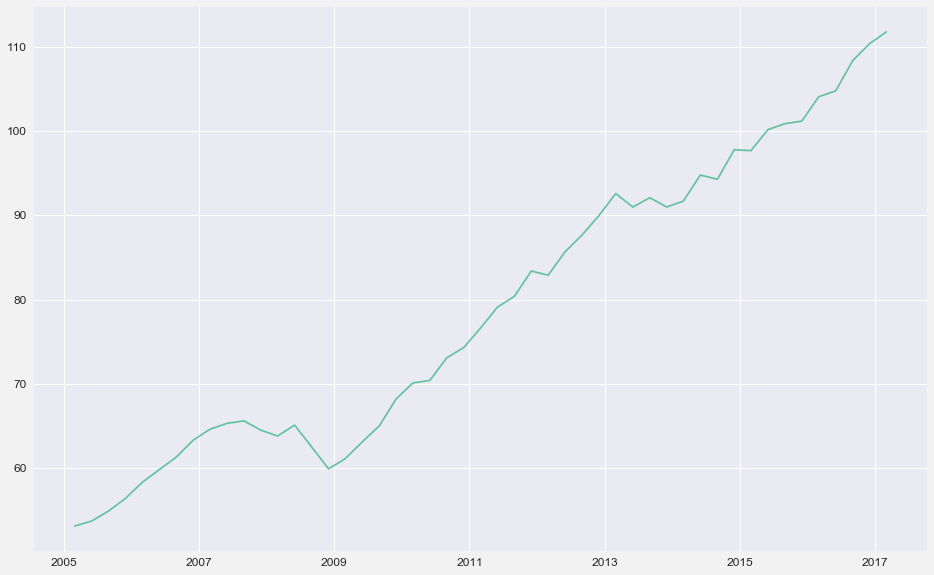

In [206]:
fig, ax = plt.subplots()
ax.plot(trondheim_house_prices.date, trondheim_house_prices.boligpriser)
plt.show()

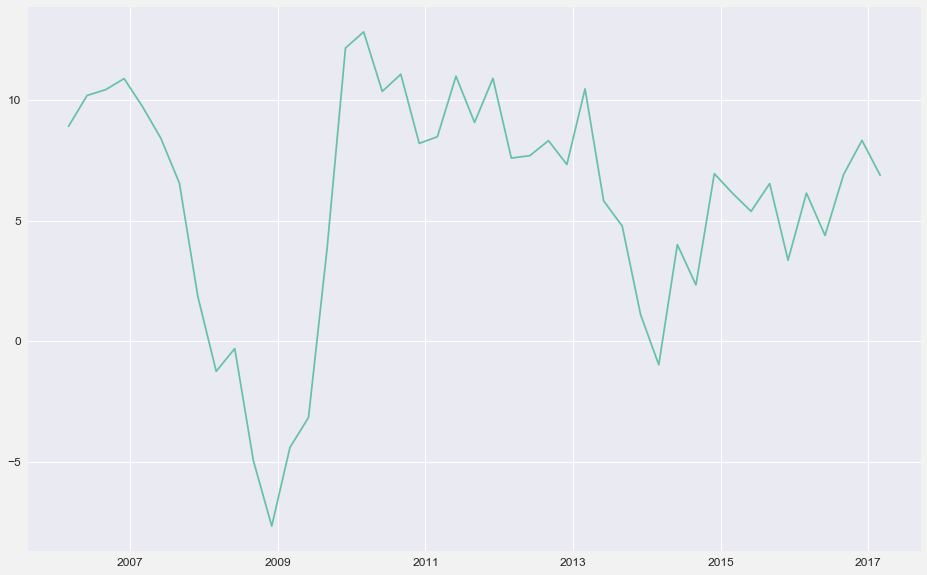

In [207]:
fig, ax = plt.subplots()
ax.plot(trondheim_house_prices.date, trondheim_house_prices.perc_chang_priser)
plt.show()

#### movement to trondheim

In [208]:
trond_innflytting = innflyttinger.loc[innflyttinger.region == "Sør-Trøndelag",]
trond_innflytting = trond_innflytting[["tid", "innflyttinger", "utflyttinger", "net_migration"]]
trond_innflytting.columns = ["date", "innflytting", "utflytting", "netto_migrasjon"]
trond_innflytting.head()

date  innflytting  utflytting  netto_migrasjon
5028 1951-01-01       8946.0      9592.0           -646.0
5033 1952-01-01       8117.0      8981.0           -864.0
5038 1953-01-01       8868.0      9422.0           -554.0
5043 1954-01-01       9067.0      9305.0           -238.0
5048 1955-01-01       9560.0     10130.0           -570.0

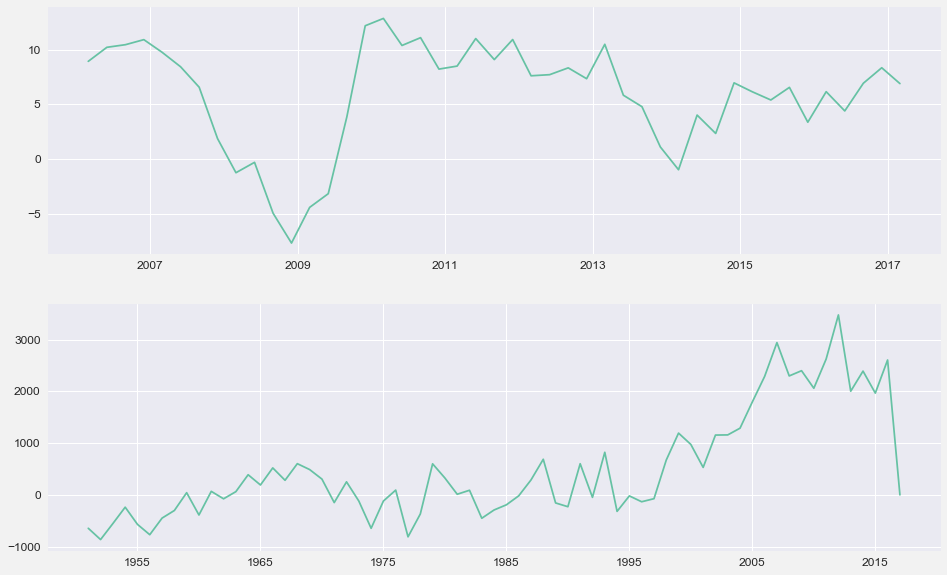

In [209]:
fig, ax = plt.subplots(2)
ax[0].plot(trondheim_house_prices.date, trondheim_house_prices.perc_chang_priser)
ax[1].plot(trond_innflytting.date, trond_innflytting.netto_migrasjon)
plt.show()

#### igangsatte

In [210]:
igangsatte.head()

region  statistikkvariabel        tid  boligbygging
0  0 Hele landet  Igangsatte boliger 1993-01-01        1072.0
1  0 Hele landet  Igangsatte boliger 1993-02-01         967.0
2  0 Hele landet  Igangsatte boliger 1993-03-01        1011.0
3  0 Hele landet  Igangsatte boliger 1993-04-01         915.0
4  0 Hele landet  Igangsatte boliger 1993-05-01        1093.0

In [214]:
bygging = pd.read_csv("http://data.ssb.no/api/v0/dataset/26025.csv?lang=no", sep=";", header=0, decimal=",", encoding = "cp865")
bygging["region"]=bygging.region.astype('category')

fylker = ['Oestfold', 'Akershus', 'Oslo', 'Hedmark', 'Oppland',
       'Buskerud', 'Vestfold', 'Telemark', 'Aust-Agder',
       'Vest-Agder', 'Rogaland', 'Hordaland', 'Sogn og Fjordane',
       'Moere og Romsdal', 'Soer-Troendelag', 'Nord-Troendelag',
       'Nordland', 'Troms', 'Finnmark',
       'Svalbard']

bygging["region"] = bygging.region.cat.rename_categories(fylker)

bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
bygging.statistikkvariabel.cat.categories
variabler = ['Boliger under arbeid', 'Fullfoert bruksareal (1 000 m2)',
       'Fullfoerte boliger', 'Igangsatt bruksareal (1 000 m2)',
       'Igangsatte boliger', 'Under arbeid, bruksareal (1 000 m�)']
bygging["statistikkvariabel"] = bygging.statistikkvariabel.cat.rename_categories(variabler)
bygging.rename(columns={"Boligbygg, etter region, statistikkvariabel og tid": "boligbygging"}, inplace=True)
bygging["tid"] = pd.to_datetime(bygging.tid, format="%YM%m")
bygging["boligbygging"]=bygging.boligbygging.astype(float)

In [215]:
bygging.region.unique()

[Oestfold, Akershus, Oslo, Hedmark, Oppland, ..., Nord-Troendelag, Nordland, Troms, Finnmark, Svalbard]
Length: 20
Categories (20, object): [Oestfold, Akershus, Oslo, Hedmark, ..., Nordland, Troms, Finnmark, Svalbard]

In [216]:
#bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
trond_fullforte = bygging.loc[bygging.statistikkvariabel == "Fullfoerte boliger", ]
trond_fullforte.head()

region  statistikkvariabel        tid  boligbygging
1168  Oestfold  Fullfoerte boliger 1993-01-01         148.0
1169  Oestfold  Fullfoerte boliger 1993-02-01          42.0
1170  Oestfold  Fullfoerte boliger 1993-03-01          26.0
1171  Oestfold  Fullfoerte boliger 1993-04-01          29.0
1172  Oestfold  Fullfoerte boliger 1993-05-01          39.0

In [217]:

trond_fullforte = trond_fullforte.loc[trond_fullforte.region == "Soer-Troendelag", ]
trond_fullforte = trond_fullforte[["tid", "boligbygging"]]
trond_fullforte.columns = ["date", "fullforte_bolig"]
trond_fullforte.head()


date  fullforte_bolig
25696 1993-01-01             84.0
25697 1993-02-01             54.0
25698 1993-03-01             89.0
25699 1993-04-01             57.0
25700 1993-05-01             55.0

In [218]:

t = len(trond_fullforte.date)
T = [i for i in range(t)]

s_fullforte = UnivariateSpline(T, trond_fullforte.fullforte_bolig, k=3, s=2000000)
smooth_fullforte = s_fullforte(T)

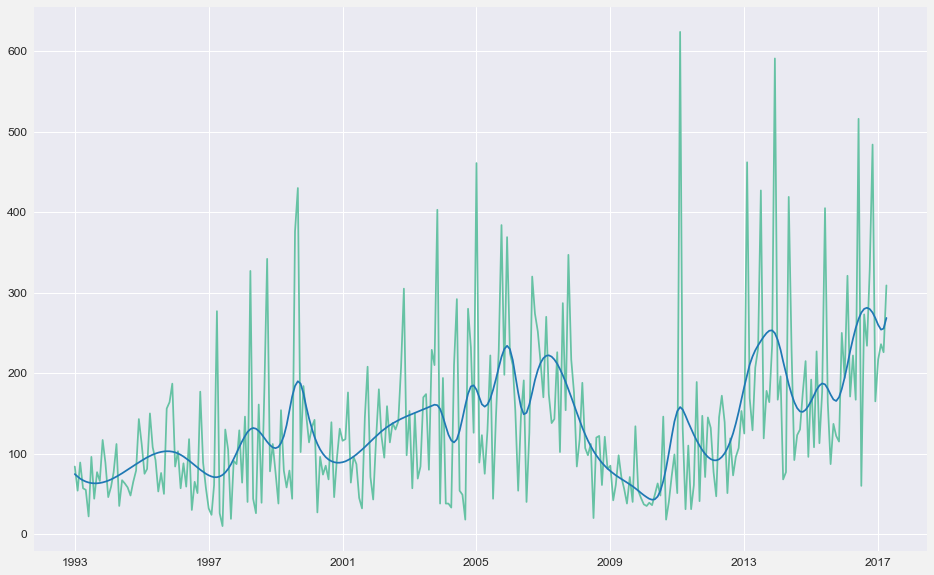

In [219]:
fig, ax = plt.subplots()
ax.plot(trond_fullforte.date, trond_fullforte.fullforte_bolig)
ax.plot(trond_fullforte.date, smooth_fullforte)
plt.show()

In [220]:
smooth_data.head()

date       Oslo   Hordaland    Rogaland  Soer-Troendelag
3504 1993-01-01 -18.215382  129.967503   86.939034        46.225609
3505 1993-02-01   9.368438  125.672868  104.479728        48.680539
3506 1993-03-01  34.497111  123.124961  120.414966        51.150916
3507 1993-04-01  57.263867  122.163363  134.808047        53.637779
3508 1993-05-01  77.761934  122.627658  147.722272        56.142168

In [221]:
trondelag_smooth = smooth_data[["date", "Soer-Troendelag"]]
trondelag_smooth.columns = ["date", "igangsatte"]
trondelag_smooth.head()

date  igangsatte
3504 1993-01-01   46.225609
3505 1993-02-01   48.680539
3506 1993-03-01   51.150916
3507 1993-04-01   53.637779
3508 1993-05-01   56.142168

In [222]:
ingangsatte_trondelag = Soer_Troendelag
ingangsatte_trondelag.head()

region  statistikkvariabel        tid  boligbygging
24528  Soer-Troendelag  Igangsatte boliger 1993-01-01          36.0
24529  Soer-Troendelag  Igangsatte boliger 1993-02-01          58.0
24530  Soer-Troendelag  Igangsatte boliger 1993-03-01          43.0
24531  Soer-Troendelag  Igangsatte boliger 1993-04-01          31.0
24532  Soer-Troendelag  Igangsatte boliger 1993-05-01          95.0

In [223]:
ingangsatte_trondelag.tid.max()

Timestamp('2017-04-01 00:00:00')

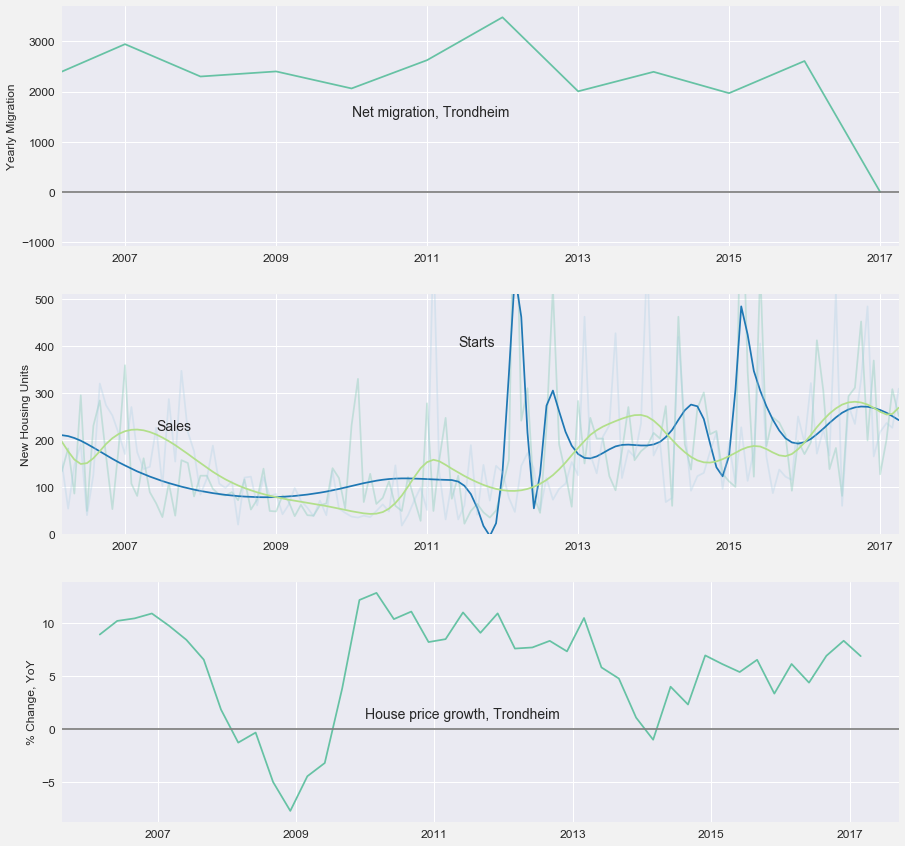

In [224]:
fig, ax = plt.subplots(3)
ax[0].plot(trond_innflytting.date, trond_innflytting.netto_migrasjon)
ax[0].set_xlim(pd.to_datetime("2006-03-01"), ingangsatte_trondelag.tid.max())
ax[0].axhline(color="grey")
ax[0].set_ylabel("Yearly Migration")
ax[0].text(yearmonth("201001"), 1500, "Net migration, Trondheim")
ax[1].plot(ingangsatte_trondelag.tid, 
           ingangsatte_trondelag.boligbygging, alpha=.3)
ax[1].plot(trondelag_smooth.date, 
           trondelag_smooth.igangsatte)
ax[1].plot(trond_fullforte.date, trond_fullforte.fullforte_bolig, alpha=.3)
ax[1].plot(trond_fullforte.date, smooth_fullforte)
ax[1].set_xlim(pd.to_datetime("2006-03-01"), ingangsatte_trondelag.tid.max())
ax[1].set_ylim(0, 510)
ax[1].set_ylabel("New Housing Units")
ax[1].text(yearmonth("201106"), 400, "Starts")
ax[1].text(yearmonth("200706"), 220, "Sales")

ax[2].plot(trondheim_house_prices.date, trondheim_house_prices.perc_chang_priser)
ax[2].set_ylabel("% Change, YoY")
ax[2].text(yearmonth("201001"), 1, "House price growth, Trondheim")
ax[2].axhline(color="grey")
fig.set_size_inches(15,15)
fig.savefig("figures/trondheim_housing_market.png")
plt.show()